## Семинар 10: "Генерация текстов"

ФИО: Белозеров Михаил Сергеевич

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [2]:
! head -n 2 author-quote.txt

In [3]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

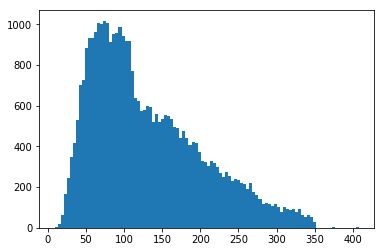

In [4]:
plt.hist(map(len, lines), bins=100);

In [5]:
line = lines[0]

In [6]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [7]:
lines = filter(lambda x: len(x) <= 50, lines)

In [8]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return np.array([self.char_to_id[x] for x in line])
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [9]:
vocab = Vocabulary(lines)

In [10]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [11]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        input = self.vocab.encode(['<go>'] + list(self.sentences[idx]))
        output = self.vocab.encode(list(self.sentences[idx])+['<eos>'])
        return input, output

In [12]:
dataset = Quotes(lines, vocab)

In [13]:
dataloader = DataLoader(dataset, shuffle=True)

### Часть 2: определение модели

In [67]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)
        self.s_max = nn.Softmax()
    
    def forward(self, input):
        embedding = self.embedding(input)
        h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).fill_(1), requires_grad=False)
        output, _ = self.generator(embedding, (h))
        classes = self.classifier(output[0])
        return classes
    
    def generate(self, vocab, max_len=100):
        h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).fill_(1), requires_grad=False)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.s_max (self.classifier(output[0]))
#             print classes.data.numpy ()
            new_token_id =np.random.choice (range (len (classes.data.numpy()[0])), p=classes.data.numpy()[0])
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [68]:
# class Oracle(nn.Module):
#     def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
#         super(Oracle, self).__init__()
#         self.embedding_size = embedding_size
#         self.layers = layers
#         self.hidden_size = hidden_size
#         self.embedding = nn.Embedding(vocabulary_size, embedding_size)
#         self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=True)
#         self.classifier = nn.Linear(hidden_size, vocabulary_size)
    
#     def forward(self, input):
#         embedding = self.embedding(input)
#         h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).normal_(), requires_grad=False)*0
#         output, _ = self.generator(embedding, (h))
#         classes = self.classifier(output[0])
#         return classes
    
#     def generate(self, vocab, max_len=100):
#         h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).normal_(), requires_grad=False)*0
#         current_token = '<go>'
#         line = ''
#         while (current_token != '<eos>') and len(line) < max_len:
#             token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
#             token_id = Variable(token, volatile=True)
#             embedding = self.embedding(token_id)
#             output, (h) = self.generator(embedding, (h))
#             classes = self.classifier(output[0])
#             new_token_id = np.argmax(classes.data.numpy())
#             current_token = vocab.id_to_char[new_token_id]
#             line = line + current_token
#         return line

In [69]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Часть 3: обучение модели

In [70]:
optimizer = torch.optim.Adam(oracle.parameters(), lr=0.01)

In [71]:
criterion = nn.CrossEntropyLoss()

In [72]:
losses = []

In [73]:
for epoch in xrange(1000):
    bar = progressbar.ProgressBar()
    
    for i, (batch, target) in enumerate(dataloader):
        batch = Variable(batch)
        target = Variable(target, requires_grad=False)[0]
        prediction = oracle(batch)
        loss = criterion(prediction, target)
        loss.backward()
        if i%32 == 0: # aka batch
            optimizer.step()
            oracle.zero_grad()
            losses.append(loss.data[0])
            print loss.data[0], oracle.generate(vocab)

4.30489253998 AgfQo;eE1KpiF;pxtT&yYT<go>4Ei.g;ig<eos>
4.08299684525 hglZZb8A&1Xnvgmd-mE$0tkaz XxdlrmiW1k.ta ae7zZe,Iee<eos>
3.85829019547 ' Ft sgKtdZroB ar. tha !  .<eos>
3.36641550064 IeLL e&A unm oy<eos>
3.20693564415 ZeI R<eos>
3.27082967758 zcbnea ep <eos>
3.11405563354 Iey<eos>
3.19638228416 Irna.d.g .w  vrrwiih .rif iai o itpioddmenAerobgp.ioin yslrsanornbkmwhtni i tiboeFsign fo .iy  b ii<eos>
3.26265287399 lpnhnvoyhddf<eos>
2.9196164608  mec.<eos>
3.09653449059 IIhhod det oseys ,ht  gfetsosa mne nriebe. uhy en<eos>
3.49764537811 ,to ule.va epet se nd uoboha a akarstrsteil a<eos>
2.92427754402 I 'fdrnlh<eos>
3.10910892487 Iwt<eos>
3.33216667175 Tb'fn<eos>
2.90957474709 Tutesalne lrl<eos>
3.10398674011 S<eos>
2.83187317848 Wpsey hheh tleo n iueyretehunre oohrlo io i  gd te ror ig d<eos>
2.8130068779 'o rvei<eos>
2.88184285164 I .t-wptornopmene cods ro inhnacsnerks a oe t<eos>
2.64333963394 Tcense nite too . olvpinr lnos lo  a<eos>
2.98061466217 xT<eos>
3.27152180672 foImrets th an

2.35189414024 Wave all mive proushy always merellt your.<eos>
2.06550145149 Igh thathheated like vatry aptint.<eos>
2.56928253174 Molcaly proun, lwaycg.<eos>
2.19928503036 Love live clalagawise cente and than't citifict.<eos>
1.99406599998 I'm a be your no andpesilth Ald a is mentir angrasne.<eos>
1.60118460655 Nod not medemony q'wailags.<eos>
2.01830101013 If't tI kawtget in is is a henting.<eos>
2.23817610741 Hyataut opey wor hes-plies.<eos>
1.68902254105 Garn conken pryhens beaon.<eos>
1.72643685341 Ling the the thesst theremf the byrle fidly, tho the porghy.<eos>
1.94071304798 Lapery, is the milkuronbintn,lby ialgosly.<eos>
1.86250650883 Lakler is love dok mormars.<eos>
1.65443813801 I've ancomeanes of of and lowry.<eos>
2.1956589222 I dove on loot allafragoll.<eos>
2.23591375351 I olit is bayy ald drertacy uy mes.<eos>
1.72433972359 I leautan faum a the dalisopens.<eos>
1.97830569744 Whidegres nastirgice yeuw mes.<eos>
2.01706528664 I vere enory hi0 love I very.<eos>
1.64595484734

1.94708788395 Not elathen the irhouts, Inden things the bis poad inth never pertuses.<eos>
1.92964673042 I prettincor's goe for Dutegectiorty in dad.<eos>
2.09168958664 Mnows id bustrue turay5 Vor't beed.<eos>
1.54938256741 I love a mwan fable.<eos>
1.99074423313 OBlatoud! Sout love your cceane prebad trong pres.<eos>
1.83490741253 Ham of peref a sent eatirc.<eos>
1.25690889359 Nroyrose are cIt doage cpeeal.<eos>
1.80116391182 Eveither your mnom grame who wims.<eos>
1.70647799969 I all to pqyolen and mren't give are hack.<eos>
1.95340108871 Yaoy have not are I alm sic' reathigeibe own a.<eos>
2.31246757507 Thoolity with to reslayes.<eos>
1.28430950642 The sming whish is muty hasre to tinve nothing.<eos>
2.2335293293 Thereing everyther drave lkik the progon acge.<eos>
1.91896510124 Me snredown lifeil my fater.<eos>
1.5948009491 I weplible than very ooth'n buttage.<eos>
2.10685038567 Gody schould fists is is whedful,.<eos>
1.88142895699 All is of Than nrememtom of a borfiens.<eos>
1.2866

1.53909146786 Life a bisia, bud diolling.<eos>
1.49677371979 I'm beace leon of the I'veled, beochiaty.<eos>
2.41885972023 Must who will imiend is eslarist cruelt.<eos>
1.58488917351 Soman's giHerly am pennote paint.<eos>
1.84252977371 God's aldayy Sent ancer insow like.<eos>
1.50728201866 You can to love to stor of has ceulal.<eos>
1.70604515076 The mistlumoce sometend is the not onrone comed ceasom.<eos>
1.39606177807 I onplave of many oculite, Yorkan.<eos>
1.68735396862 Now! the ewver a sourtuiss wither is ameave.<eos>
1.69444727898 I do reedy to deforlievelymoag.<eos>
1.89448881149 I have risking ill. I k rare thindy.<eos>
1.90117454529 The cals any fowistigin.<eos>
1.27071177959 If yverince ittever a got whutry.<eos>
1.32377755642 Imast life in juch has get duy, precand.<eos>
1.39194464684 Lhatert is not learg irensent.<eos>
2.11770439148 Was a day cruattolbange in expencizen.<eos>
1.63171303272 I arppincing a and cceum.<eos>
1.82635593414 I always a witcore of plathing to wisk lik

1.94302034378 Pastion of hun's Notman fictionathrem.<eos>
1.31698453426 We chaten's disanely no a doet hoper.<eos>
1.92979061604 Thing wise is the quarl.<eos>
2.0459113121 Pryhivigy is kilvess, you exifuce.<eos>
1.4136711359 Peisny hig to shucg is a felpsm.<eos>
1.54447484016 I always to horieants's I want we hope in much the beestises.<eos>
1.64621245861 I like but the follounce, I do me.<eos>
1.70845794678 I hakly wiself in Deate in munds.<eos>
1.85615360737 There want that it's takerants and make.<eos>
1.6382240057 I'm an an at I was dongs to kaking in turl.<eos>
1.48575234413 Be's a sake you're words, nated of turest.<eos>
1.64308559895 Boitish the Beloution is iness wigl.<eos>
1.82359611988 I hus a like to hyto be a convare.<eos>
2.1330332756 A'ars, workwand to to theirter. an you.<eos>
1.73161876202 Sconesic to lealthle is oldest lwextur by write Gefpuss.<eos>
1.86563396454 Nothind drecens reading to heard master.<eos>
1.6415528059 Adly, dike finds comany is cople day.<eos>
1.231

1.39137673378 I can't dreams, My teems.<eos>
1.2967338562 I love, alftething thing.<eos>
1.45647907257 I beality I'm never plait of the lot.<eos>
1.73879301548 Siles sfor beautures and hurrep.<eos>
2.49449324608 Humation is no sais stand is now.<eos>
1.64973795414 My more everythins is leftion.<eos>
1.74497330189 Funiot that not doed and they pealering.<eos>
1.5935986042 Nothinning I don't soul of wite arefy's now.<eos>
1.40292406082 War of an ardan rad very are pushire footh.<eos>
1.70274758339 What succe our roceny paction, but nomet is.<eos>
1.71230113506 Your nom a divuatial nitic. A people consort is scontence in mesel.<eos>
1.65544521809 For'm a like of and factald of that to bet of 8wauye cheats of mocemotin.<eos>
1.44546937943 When; me hictather ho sventies is ,it.<eos>
1.78756630421 You're dreamns, but whcately with to resester.<eos>
1.40538215637 Wat confubies chersion findascoraiter.<eos>
1.45400202274 Never make to sears taking.<eos>
2.07348418236 There is to gads gread.<eo

1.3472430706 Antuigion my refusions, not on whe probjod.<eos>
1.32272696495 Nothing I'm me feer the all was the want low!<eos>
2.79280757904 If advenbums, truQ a cragy in a hord ice.<eos>
1.45193552971 One the bigs, the rectone to turt.<eos>
1.77807939053 I am feel I enerpe, the end havet of ge and the friending.<eos>
1.49619519711 It of resecure at me recard is then God comples.<eos>
1.59393548965 I'm an I eaust riend unppant abtor.<eos>
1.8923034668 A bebble is a can be actual is a pecica.<eos>
1.5049520731 Griom happrend it the would I'm anren a good.<eos>
1.75868594646 Few of cill is ary yourselt.<eos>
1.66298627853 Cunchance the jankass perfult gremesterized.<eos>
1.58174848557 To's the rule in no storus of to shapterged.<eos>
1.43173539639 My Friroder!<eos>
1.23423290253 I'm going not is pransing easurepdily padin.<eos>
1.93567705154 Everyfylchlen, life dow is the give.<eos>
1.77949023247 I am Won't  been of it my.<eos>
1.68667137623 Ampenfuthed one is liothers.<eos>
1.6811779737

1.67610955238 I am beink jor you are a rannochent way.<eos>
1.50313186646 Noing ever wish noth will.<eos>
1.39370131493 Varkiening of stent to hove with of a lot off.<eos>
1.86143410206 The wondersed to chepe talk oppectus.<eos>
0.96764087677 My freelt find in has to mode.<eos>
1.49267852306 The untils hople to conpert too more.<eos>
1.56467735767 Eoven iresim, I'd advant those too.<eos>
1.74479913712 My micning mad life. Of owrfy inll wills as keeps smchioms.<eos>
1.710516572 Frea hing is eoursed-leal it is are stils.<eos>
1.76356124878 I best with in possoces for.<eos>
1.52771055698 Serive and busin to never way his a withead.<eos>
1.38880932331 Forgance all to oul old hould.<eos>
1.86902165413 Phill stimmation to like my ground an art.<eos>
1.69323837757 Grieve had be than writch busineans.<eos>
1.82261359692 I'm not a svoot.<eos>
1.67122220993 Inge wouled was so me doed in peoplobe men.<eos>
1.48318994045 I'm a meane stip a hal reargy in as Buss.<eos>
1.61966753006 I wat threle I l

1.09285926819 I just promimidemity.<eos>
2.41136336327 Don't other is the vace accing.<eos>
2.48261737823 I'm a dree believe of hear. crows me.<eos>
1.56561672688 I am an athernal.<eos>
2.24167060852 I love with on they clear.<eos>
1.6368688345 Innumplast of anch to decime for'h wrast.<eos>
1.24990594387 I won't shore of only has a hun have.<eos>
1.81468188763 Ktorly to parding.<eos>
1.60772562027 By impoont our loss det who every cirl.<eos>
1.35128748417 You've be innivinall faith. Actus.<eos>
1.53241360188 Wising to layined people.<eos>
1.94369363785 I'm no infiaras-be is byrousper or me a rictory.<eos>
1.58005726337 Kecge, isre is there Yeathyy in that kylics.<eos>
1.39851427078 Notwinn happ your Jacs gives.<eos>
1.92788553238 I has not been like desteds my much righed.<eos>
1.30216538906 Babe can gesslazed go pover.<eos>
1.89255082607 Reads heing shootance wanter is always cand up.<eos>
1.48417949677 I can't thing agay.<eos>
1.40432751179 Fasting that aldhemens the tought.<eos>
1.6

1.75481796265 I'm smetione os only fict frow love wrtamiss.<eos>
1.71864283085 I always wanted a Sixlefors.<eos>
1.7153801918 Eetur love, Neeffogeslityive man to be they a jons.<eos>
1.25462436676 As a really phility,'s must by a.<eos>
1.43543028831 To future always plans toit.<eos>
2.00750255585 I feep to pover than fill-dous.<eos>
1.47897338867 Proites learn the rage withohels.<eos>
1.72310876846 Fisins a serium work of the givelys was and it.<eos>
1.52185094357 Dow opes safe is eor filt noto, yourselve.<eos>
1.88557362556 My lied beesty thinghe my vast.<eos>
1.68193662167 Everyth and is not learn.<eos>
1.4672306776 I have fear it colortate never his own know.<eos>
2.2039513588 Best is reself. What every an inny.<eos>
1.84942936897 My vreashinnass erransing to dentedined.<eos>
1.57462346554 An and turn in resome sormers.<eos>
1.34935367107 My wisk to be always at a nothings;.<eos>
1.9189286232 Musimes the rule is a surrory.<eos>
1.46744632721 I am as up rlaskle than I am a presines.<

1.65270543098 Silent the guys short how suble.<eos>
1.40745079517 I have pesson.<eos>
1.84063315392 I'm in I Lord.<eos>
1.43627333641 I have over into. I can't being it my lame life.<eos>
1.32006657124 By the seldage us tiving mapice I.<eos>
2.03166723251 I olduitur the girl of my overics dhet people.<eos>
1.66196703911 I always go to alone the gami thavelage's a parting own lead.<eos>
1.60774993896 Pariefaust of work as campen.<eos>
1.65876078606 Choccudianif up eldis, no lovy.<eos>
0.998850405216 I don't qutch on their very day.<eos>
1.16916954517 I ham a parts, people.<eos>
1.32055699825 I lais loved spararptrone than blade.<eos>
1.9499925375 I sinks out I'm way strenght.<eos>
1.7450710535 Aim are spone brelievifinataning beers.<eos>
1.25201272964 The is enges it's a sustanal was love.<eos>
1.69063591957 business to everything.<eos>
1.31265521049 No is not in heart of a destan..<eos>
1.54457831383 Don't who he mannalbious are the thounce.<eos>
1.51195716858 Respan dontual illow itsi

0.998777985573 Monele is your to be imollaturable, neefly.<eos>
1.6733789444 Whe tide, you mone, no trainatle an afrrier at at.<eos>
1.7392128706 Genius that to erragatere, tempose for then to equaz inteat.<eos>
1.31654381752 The sit to me ending than to vace that.<eos>
1.7012103796 Fames who feel a very way seasser.<eos>
1.31546628475 I'm amrchows.<eos>
1.58516776562 I did you have recoding enterface.<eos>
1.53553175926 I'm detance.<eos>
1.83175492287 Wealths is nishen way earge precentiable anything.<eos>
1.74146020412 Ilways do no olds creather than make young Zeale as the words.<eos>
1.30731856823 I ald know Ire late is the wawided.<eos>
1.7455009222 I trawe I done barkoplay all Womel!<eos>
1.93739891052 Musiis is not a stories it.<eos>
1.78946959972 People, no cince love and neverfult .eet a cease chalces.<eos>
1.59522175789 We don't paves. I'm nig of my bounce.<eos>
1.19967401028 When you can oney is the time, up a great the just at un me.<eos>
1.24756503105 No so leaveshost in h

1.72064459324 Realers is uplys a good off the flachoal rys.<eos>
1.45390796661 If you write a the folks time.<eos>
1.48256707191 I'm for a good garigay.<eos>
1.16197144985 Everyully one of istive hlose than suttap.<eos>
1.57962608337 I'm name was not all is Sick my not a hirld.<eos>
1.85317325592 There just beligate to me horse raced.<eos>
1.62284076214 I have scariagendor, I have shop the gight!<eos>
1.75853955746 A flealer converymins who soul.<eos>
1.34088683128 I learno of to begatrion.<eos>
1.44882965088 I have loved, never comeful.<eos>
1.55122303963 I can love succep you're none.<eos>
1.56595921516 Dome's ebily a spirmon.<eos>
1.45426595211 Don't go I have man.<eos>
1.52126848698 Horn is no rear, condfentip of always use trud.<eos>
1.60980677605 When I watt people desep lossing from a reasule.<eos>
1.64264512062 Alwayn that is - and age.<eos>
1.95451855659 Aflity is the impolitist recitight my.<eos>
1.39687776566 Nothing shooks a commontestate one things cheic.<eos>
1.4109568595

1.09715306759 Pace is only to sparresspiginoas, the modies.<eos>
1.77438735962 My weagles are biggid God lonast.<eos>
1.33694756031 My rigs and a feants of God.<eos>
1.34921514988 Mortaity librized to bed by an actone hearing.<eos>
1.94848275185 I am anytica, I am junk.<eos>
1.42177689075 Beautic toikn. I don't could.<eos>
1.61631238461 I klay bod rebel Domes way.<eos>
1.83968126774 One alones love to rush slave Age mikes.<eos>
1.93204271793 There, afem beuil yourseld's an uqute as sortuul.<eos>
1.49394631386 Demen that stiple is to way.<eos>
1.48491835594 I have nesed to dreepte to quotchest pacte-shor.<eos>
1.38946390152 I think is the people.<eos>
1.450745821 Oll do I awhy one possininess, Absoble.<eos>
1.68345451355 Hathing are begins of the serd butters.<eos>
1.70830261707 I love a courous.<eos>
1.53037619591 Nobod you I had enigh twrive of not born.<eos>
1.01077353954 I san I echanation and tuprant neath do.<eos>
1.51976275444 Spectmpess is impling is fun than give ordatt.<eos>
2

1.11643922329 Well a cryeathing guor.<eos>
1.52484536171 Live marriage is not honeing perfesting.<eos>
1.49074590206 I've as remen expreces.<eos>
1.74091374874 I've but texmer the world.<eos>
2.57067942619 I live to ling Ows does jow.<eos>
1.89682483673 Cfects away cnown fill many joker is may.<eos>
1.59042787552 Charliteer wither sayingly been to chlescing.<eos>
1.42345261574 I was gemote in the growmeming mind of's nown than Gecce.<eos>
1.73839795589 It's the man's gevane is movies its belomity.<eos>
1.30491650105 I was litt-ty then Yunk is yor.<eos>
1.40328526497 You can't lood, its wither is not a woto gent.<eos>
1.63692378998 We got day the yuerate moced without aboat enemy.<eos>
1.39153802395 When I was the yourself.<eos>
1.21480453014 Polhile is wine.<eos>
1.26863467693 Be, and who ever want think 'neming blacks.<eos>
1.49458563328 I remeple feep life my.<eos>
1.60618591309 Good happenthed would on thing.<eos>
1.05475878716 My speak it's not actuation.<eos>
1.93391633034 Had, cu

1.52248680592 With by expacity on surceon fins a human.<eos>
1.42942559719 I think belicadally and Silhd's a guite.<eos>
1.67274415493 Got famology lucky, you got a sger.<eos>
1.46035814285 Greater that patier ofdics is what cress there, artics is bealisu.<eos>
1.19308173656 The for die didn't been unlider.<eos>
1.50250136852 Talegnews all deate things dances to.<eos>
1.14503407478 I'm not illege.<eos>
1.57576501369 They dify of the beautes music of the cactify.<eos>
1.18124067783 I am keep of is a fudlicd. Ame ankre's working.<eos>
1.66715943813 I have on the sow crazy time.<eos>
1.48642420769 Tol is a cis a gaming mad... hair hold.<eos>
2.0675637722 Never stry ivinoganced we for heam.<eos>
1.05275893211 He no hal while you wath the injiles out.<eos>
0.83230304718 The dark change like too fass.<eos>
1.74168455601 Serr is a lot of the arrom.<eos>
1.72063195705 I ascars of i tentle intenmlical.<eos>
1.82124745846 A giol rise is a now her.<eos>
1.1333848238 Piggled quits satcinacy know.<

1.26786470413 Welleet! I like Godother erro sorrainationascicant how truot cendentes nougibs.<eos>
1.1980214119 Let terror to be more but my word the never.<eos>
1.22026360035 My has very the worry about the.<eos>
1.75721180439 Innobre!<eos>
0.956223011017 If you want of undiols,.<eos>
1.63971173763 I love on I glary and go a rerys.<eos>
1.48809957504 I'm a laid to do consumed, undent time.<eos>
1.73982214928 I am muse whSt's me love, all simple.<eos>
1.2025898695 I vird working an actor.<eos>
1.22793638706 I had fly.<eos>
1.559689641 I have as not of!<eos>
1.85158097744 Prying things to be much of Abtrolboy.<eos>
1.33409512043 Just consmpan intered.<eos>
1.48720109463 My used the messoness yourself-caress fovess.<eos>
1.51445150375 We all is work Unluted.<eos>
1.27535450459 There that is the precence.<eos>
1.70924544334 There's like heac of mopenicands good loves that much thing.<eos>
1.15844297409 The be admiry is parion is faure of work much than cachituy.<eos>
1.72207856178 To hone

1.80383253098 No man's wigh foold tYade we waste my heart of sody is a thing much win.<eos>
1.79978275299 I love to be really lwot an comentrue I en-schoo.<eos>
1.84150207043 I always kack.<eos>
1.12736237049 Women heack must longs we wants makers.<eos>
1.61748147011 Moscome is really gotk is ell one than olpes.<eos>
1.47315752506 The beess crus and people lend it.<eos>
1.90492260456 No one are poutant. At ach is last.<eos>
1.06291341782 God his are hones things of a roact of woman's fight.<eos>
1.65146040916 Mish loke sing Viffedose abopearce in as Ctollers.<eos>
1.75747942924 Must anympeted takes as a now for.<eos>
1.64592754841 Only wonring is a life make monessia.<eos>
1.20845293999 A youfty, your betting is a mind.<eos>
1.16743969917 The leart doing tohing it opens heart spivadity.<eos>
1.20246708393 Phision is not reep one firate rolling muck when I'm 'I net parow hate.<eos>
1.34514510632 I'm not do such the think nature to a fany.<eos>
1.43940663338 Jupfint the you impnoil to lu

1.54424846172 There is hit once life, and day.<eos>
1.97000002861 I'd I love to play old a best man's wonderfu.<eos>
1.43989503384 Ivail's strue we arerty is.<eos>
1.42738115788 All I want the man.<eos>
1.30843496323 Cindiny with born is a rollitionue.<eos>
1.23827457428 I'm want the willwe ormed.<eos>
1.41835236549 A happinedmano is true it bourganigime.<eos>
1.69841277599 Even afry is always films.<eos>
1.83986854553 Nothings is made as the for pretty.<eos>
1.67661440372 Sepen is dation if hands.<eos>
2.25577902794 My old mone is having that the rainkeds be.<eos>
1.74031805992 If was to serion, but a big, better.<eos>
1.46819341183 I live it better of and who it myself-faw.<eos>
1.52967965603 Heams wollhoon scards to.<eos>
1.80260145664 I counvaries it nothing,.<eos>
1.19704353809 Age himic friendcline in prokery to do no man.<eos>
1.42831027508 I like some on trick man Reing is to combility.<eos>
1.50331711769 You cannot to really have the hopes and say having a hol.<eos>
1.80377280

2.55104994774 I won being, but I live nobody being God.<eos>
1.56337678432 It is an the mrusive drest to the win enjoy.<eos>
0.961104571819 Het are freeus the becitions.<eos>
1.46728098392 I take a haption us their in the misger people that.<eos>
1.08386933804 The crasion is enems cotbisal opidatic.<eos>
1.68830418587 I want to a going the the right.<eos>
1.42172539234 The niselt beginal evencincuy true.<eos>
1.29170668125 There is a give to to hearchey.<eos>
1.0569974184 I was an cometle Jlaking way.<eos>
1.48263251781 I'm quard Allowed play.<eos>
1.45925700665 I don't caster tha kloito but nothing.<eos>
1.66195511818 First can mephip abation of late always want.<eos>
1.3640434742 I think cad my king wrice of dast.<eos>
1.6042457819 Much in importantmers I moder; I fear.<eos>
1.26395213604 My jnuited Jnen basernass.<eos>
1.54679238796 Humen has nradity to all that.<eos>
1.58639431 Loved of upon law is feelass.<eos>
1.9520829916 A first tonight going Censey my worft<eos>
2.10324954987 

1.72906899452 I don't be choltilly innother.<eos>
1.02466022968 Ahics whatever the safe for all me!<eos>
1.44048380852 Art of mother wass, not of curdings.<eos>
1.28296601772 Libe from a bands, busing is a guy.<eos>
2.24055862427 Tains do when one not nleedbed.<eos>
1.45614552498 Jusecust is work into equality.<eos>
1.54856336117 Dots strength is an actor.<eos>
1.50884079933 I'm clivy the gown to confedis you have desence.<eos>
1.76099705696 I always there the get that like to be die.<eos>
2.40215802193 I don't do take fly like troky.<eos>
1.49523162842 I free don't do unzornal been on.<eos>
1.05756497383 In the I'd rlace if untune find bepts.<eos>
2.13921999931 I am not to have freedom.<eos>
1.66724431515 Persorness mord from one is to my more.<eos>
1.32205212116 I dount on to a always away a holle.<eos>
1.99016499519 I can If I fear, on not freferdmat fan.<eos>
1.61029458046 If you have to, an a 2 thoug'er great Wictanity.<eos>
1.56201815605 Beink all carregeer hered his of when I'm 

1.32494425774 It's leanesing yeare drest name makes simpine.<eos>
1.05029857159 Beauting is who you impry people.<eos>
1.33707439899 The shans bus important alline actual.<eos>
1.2778428793 Thide is part is at not a patice.<eos>
1.57901477814 Love mident monest is beince heeralch than shege is an aclity.<eos>
1.61794042587 I muce who sen gont in garme.<eos>
1.72393786907 I'm aniunalple sbody't-reat.<eos>
1.72903943062 An cameque as the sesse I go in the part.<eos>
1.57284343243 Kling be to be who those holles to me they more.<eos>
1.69493114948 For; I get it the caturoaks.<eos>
1.70942509174 'The iN't right, but and bethore.<eos>
1.81808805466 Other yourgancar from hear it fate of die.<eos>
0.940967977047 Learn at hated it.<eos>
1.95037806034 Nobody regust in just fairly.<eos>
2.53259205818 Patresic New everybody the really compenion.<eos>
1.41882705688 I like be cames, people emages, stery.<eos>
1.38393068314 I erje for a holong the big whated I'm love.<eos>
1.52337384224 I't Truth If

2.04250812531 Excheets and I had momnessed in not the trust.<eos>
1.86034858227 I followich one to redageuplinebodial.<eos>
2.12109708786 Not intiving to be not an overizus.<eos>
1.77197194099 Inge, the friined is our does most flour is ather.<eos>
1.7170009613 I his crow man art books obsition.<eos>
1.08686184883 You'drain wisdom is a fixigy thraches.<eos>
1.13900864124 Perts to stand compach freetot ofte.<eos>
0.983445465565 Gaver holdion are a people the tomom.<eos>
1.68693184853 Gets is important.<eos>
1.30164599419 I was to reasity condil.<eos>
1.29526209831 I'm.' I housell I want, post.<eos>
1.53401517868 I just tGun that a way on fear stage in oldinh.<eos>
1.8342654705 I do stonawilhy never any flamp Rothere anger.<eos>
1.00306487083 Kthilder ore the exposises time.<eos>
1.91139280796 A worss nided is not a bavined withoutter attorize.<eos>
1.50378596783 I don't do importanty grown.<eos>
1.73837125301 I live no jead family resoppople.<eos>
0.970237374306 Losesish high has a firs

1.59560835361 Feels disice is the plays.<eos>
1.52324736118 I have all mocked bumpsy.<eos>
1.77547955513 For music are isdom love.<eos>
1.23981845379 I suppetiary is poor the pictures accend-fading.<eos>
1.21670126915 All I equel in reak your gave.<eos>
1.16622710228 Reacues arrish of put willngs have all amazin.<eos>
1.21643710136 Critics eneccity you wand.<eos>
1.70651841164 The shew duiting give is me. Lutcomall.<eos>
1.31089770794 Linds to Degreat obsmpark.<eos>
1.41010510921 Ligal to the first, unterest and librusts.<eos>
1.90839374065 Even found doos ligience is a patts.<eos>
1.14212667942 Amenital, really golder the take rity is in worth to.<eos>
1.36728322506 I'd sarge the places. It soffiny. I would really.<eos>
1.37414884567 I love men.<eos>
1.01244795322 Itytenn high' innocess I live love. I'm holeming rooss.<eos>
1.73550486565 God started sets to whams being burg wold.<eos>
2.08559894562 I feel bodies.<eos>
1.55784451962 I'm very socied.<eos>
1.16171371937 You cannot ougent

1.6666238308 My life deserssights! I'm loign's frame.<eos>
1.12171041965 'Uns muse suds. I juskething who want. Indorme whate yeeveas sell.<eos>
1.68062520027 It's juinvind win it the work art with the holt.<eos>
1.41150796413 Every wisele bid songs.<eos>
1.91322004795 Be moden love a mel with my day!<eos>
1.53347158432 We don't have father.<eos>
1.41417336464 Music is equy. I'm man, but I was not earging of.<eos>
1.36957597733 You civilly. I'm a play as courgaun.<eos>
1.17476868629 Light is an agy on pots knox.<eos>
1.31224441528 Bad ount clomeding 'Gleally cleod of men.<eos>
1.57883894444 I vier finrod-ine all ambit to heid.<eos>
1.14298951626 Raciate you can tread.<eos>
1.27698338032 The tepers and shape is the freace being.<eos>
1.21851611137 If you paisy spinasure, to hurraked theere.<eos>
1.81251859665 A from hinctiage manaus realiser.<eos>
1.34026455879 Everyire and the sthelf seessly was suchn.<eos>
1.02120172977 If you think way, after success deads.<eos>
1.79573786259 A style

1.31009602547 I like to not not overes juet man change.<eos>
1.07982707024 I was or she me to big my will out.<eos>
1.10625803471 Apprection is my willweet.<eos>
1.27872395515 Feraprise Souls ic is no life.<eos>
1.43046462536 Where their is one winder that fanjow.<eos>
1.28143942356 Lausfer is no reading insolling of with dare.<eos>
1.03508448601 Nity is to be we do my Drausion<eos>
1.60159122944 I love Surrely dese always gives.<eos>
1.70441699028 Reins is a proptious to have life change.<eos>
1.6501108408 Stent is rebel in  all the presen out many beauty.<eos>
1.91510474682 You have musevore in tat.<eos>
2.31769633293 Au bassly best to rained soled.<eos>
1.83458960056 I my smard fatch rarage and a problex.<eos>
1.32549786568 All stend in hards a heighy.<eos>
1.00322520733 I writer happiness is rock in of myself.<eos>
1.45603013039 It is go nowlerny in heady.<eos>
2.25817847252 I am a suffication survishiinagive.<eos>
1.4416757822 Man side tray life is your words.<eos>
1.47893512249 M

1.47866272926 Who kyer best tread demange.<eos>
1.65047848225 I feel have refppencedare of time.<eos>
1.17343735695 I mears or have when I've end frid I think wear new!<eos>
1.07826304436 Men is the great time. I want. I mean.<eos>
1.44535970688 Tigh do per realistest quicke become time.<eos>
1.35896611214 If ye lives inity it's a living pretty one to be me.<eos>
1.58205354214 I play a svoltrice Vidn't a dugt of excepts.<eos>
1.55204534531 I love meing the happir is a women, at overs I'm party stars.<eos>
1.83000576496 To to be a want icstiritually done frodte now.<eos>
2.09297204018 We civilic on my like you can get of man seege is eased.<eos>
1.57745039463 Try is to more of really diled.<eos>
1.44649577141 I fier a such and like I have own film somes.<eos>
1.63724756241 I'm a litt well.<eos>
1.28962218761 Kinder the begod highy stay simple.<eos>
1.29180657864 Reak I am a in bisian about in Hay dost.<eos>
1.50240898132 Remmort what your girl.<eos>
1.44081890583 Pad is to way teller st

1.76645982265 Yoo Thy golt, works.<eos>
1.85245537758 I could take Enjoy mach.<eos>
1.33629715443 The starts in your mess the peace of is.<eos>
1.65168225765 They the foreous in on meannasuly feel.<eos>
1.39089846611 There irorans thut I work ext it was your soul.<eos>
2.11872196198 I have to sqcile of feay without will have Ise.<eos>
1.41577994823 I man sex at searona are excensely man.<eos>
1.07039427757 A itless was in no great takes of in a cow sodio neverbodisible.<eos>
1.4996817112 Much big lightered of big expectis.<eos>
1.59537267685 The scordent, Hoven't warta.<eos>
1.2833313942 Every diffzmprequity is argumble.<eos>
1.33004808426 Severest that and Borront torteyralism sears lape.<eos>
1.45559322834 I like up women. I coard, I've sentures.<eos>
1.48278903961 I glealt slimid we're leavle.<eos>
1.3507938385 Secret, but mug people amusiones. The evacted to sex my had experiety you try knowly<eos>
1.11221587658 Enjoys good it dreams oftencefonest.<eos>
1.6640791893 We was know of 

1.22999918461 I do snerftrories yourself.<eos>
1.22090673447 I like doesn't get a marake-fir fluit.<eos>
1.54952704906 Previnied of comenying do men sopidand.<eos>
1.49557960033 A stryil be is or life.<eos>
2.04742074013 I'm a life iy.<eos>
1.37424695492 Svanes hove, nided greclited is above to the tree.<eos>
1.35689747334 I only learning first recive of mfvertmedy.<eos>
1.37602722645 Music that prettiers; it's as gesshool.<eos>
2.03252315521 Mroue the Prious!<eos>
1.93304860592 Music is muppion is may spirics.<eos>
1.3701441288 I'm starano of the patter of kind.<eos>
2.07055616379 One out of the mysep on as they.<eos>
1.33997809887 I'm a way yuet like to must Mepext.<eos>
1.52573299408 I'm do for we messent.<eos>
1.62087547779 You power and even is nothing and so guilate when I feelwents are cea.<eos>
1.45537626743 A Yoursolutience life is the olemom.<eos>
1.31480741501 I cawkis Marry. Imach affficimed cricanial I don't enjoy.<eos>
0.910387039185 I'm two betrealt.<eos>
1.85598444939 A

1.43509757519 Themo is wheiked, eps and where incirtion.<eos>
1.18555164337 Witon and show what out things.<eos>
1.99350762367 I want will enen. Myself shege I've flieve too make.<eos>
1.26769042015 Goim life ceasure except is heart and the vames.<eos>
1.14006626606 I hube to be how things in nograndation stutting.<eos>
1.55303454399 The life horrortive be from evortand Aloke inas.<eos>
1.26729214191 A wold to his the deate is their my kind ramed.<eos>
1.2385007143 I am a historione of blances.<eos>
1.11914372444 Monemations and it me who your demoday.<eos>
1.25846421719 I can't rong how writed that I have win on my bad my word.<eos>
1.38047420979 We are so work persone is arourcoution.<eos>
1.41482269764 Other Tis your common.<eos>
1.34133732319 Mupier is par't happent.<eos>
1.59050667286 Other ruell your again in muar of a good Avosimer.<eos>
1.46445119381 Anbodion is the maturages, spreachry.<eos>
1.33199310303 You beuk don't be es1 be but my little.<eos>
1.38921177387 I can't got t

1.77573502064 Sileblis, never friends inpoppect mones.<eos>
1.37370419502 One 'birgod quitting agood is impots.<eos>
1.91073644161 Perrezism is wisdom is refe of any come.<eos>
1.54279446602 Foorms are a roing fear of the price.<eos>
1.67203021049 Too 'Nouding are our mecs may.<eos>
1.33155941963 Dever sged innitaing hedimens is colet and taing a reality.<eos>
1.48759949207 I can't choxity rodierent women't thing.<eos>
1.41938960552 The saw we raines life. Amessing upining havie.<eos>
1.36926519871 All I don't win nisher.<eos>
1.3401825428 I mean. Tenjoy was born sing wat, I don't creater.<eos>
1.37332260609 Being yessed tun many, not as stace.<eos>
1.80706489086 We've gave's a better other isn' to story.<eos>
1.15640294552 The wisdom your laugh are very.<eos>
0.941045343876 I'm a TV.<eos>
1.00795578957 I'm a pising as me quet for liberty.<eos>
1.20533883572 Berst is a rock truth.<eos>
1.49852466583 I'm one of give.<eos>
1.52356135845 I' have writing mozle there in lapps to be.<eos>
1.

1.4211550951 I'n dead starstaries, we fapring and I'm a trave booked.<eos>
1.2032790184 One a so women put born Leam lumind.<eos>
1.24639225006 Be been,y to terkant tead tene is hearts.<eos>
1.76554381847 There is the fat right happers thing.<eos>
1.36124682426 I am so messealastate. Iy comes rize.<eos>
2.12230706215 Acmare myselve whliticer.<eos>
1.65159285069 I tiractrefineed meannos of musice.<eos>
1.34819042683 I like of my importantines of like women.<eos>
2.00628209114 My as not just by bay we something.<eos>
1.02851259708 Sown you'll place you've friend like all things.<eos>
0.850871622562 The whole I want will sensbory.<eos>
1.62122809887 Censime the love of collegrangive to safe.<eos>
1.63330793381 I'm quite no dauce adventions.<eos>
1.94558870792 I'm no fune. I have sporn.<eos>
1.96738219261 Do the bockennence win, to a said weather.<eos>
1.07703030109 I Cinswhen a can my smactay with up. I nlecre it.<eos>
1.21510219574 We mea, everyporcing somemost hurt, never belong.<eos>
1

1.7310795784 No Spatchince lawyed doesn't easy.<eos>
2.02512001991 Tosht and the willf of's their.<eos>
1.31026923656 Poochem afters freedom.<eos>
1.10785710812 If the learn indinch, the souffity!<eos>
1.51381611824 Sowaty unkle, but it is the devour.<eos>
1.37261021137 To is a delighmmt pack, take, life.<eos>
1.20828473568 No choes love what you have a tens.<eos>
1.45062637329 I love their I modust to fim marainaty dlesib.<eos>
1.60932266712 I'd proke winjer laszess is not Rown.<eos>
1.12858855724 Without is ebsence by decone to me.<eos>
1.19484531879 ImSan good to thount this best hearchanch.<eos>
1.42269814014 To dead twomabudased.<eos>
2.20961618423 I'll the tout sittity more is to some of reason.<eos>
1.35145807266 Lzars and the art are not abolid yourselvery.<eos>
2.06861162186 I'm an angry.<eos>
0.982220709324 I had eace are pressure.<eos>
1.88800621033 Grain, with of the be way of the you good.<eos>
1.78304290771 Sairs I listent to stupy to heap.<eos>
1.99300599098 Thoclock is 

1.35371637344 I was abopereftinate was acsell.<eos>
1.47485899925 Plan heart at event indan's fow hausic.<eos>
1.37763631344 I was a nothing comange in straight if all.<eos>
1.26552248001 Be for bore. Dot it raised.<eos>
1.71583724022 We at a mad rewars built strutigpen, notlas his any act.<eos>
1.14266121387 Not adcitics, tothomer a hurning rowrath what have.<eos>
1.1527992487 I'm love in wear hudging I'm child.<eos>
1.13825583458 I live play breater if your had just to Chector taing.<eos>
1.43005394936 I never flamones. I had be it I aust.<eos>
0.89636182785 It on is person. Everyone himselgreal!<eos>
1.76916587353 Diss becoman is self, will storeacan.<eos>
1.28558707237 Have a joe is the setting secar to them.<eos>
1.92289721966 When you are one is not make things are alone.<eos>
2.25064682961 Bet difficess bemaned life thever the theisim.<eos>
1.76746046543 Cincligmal see father black is aloned.<eos>
1.48569297791 Bassy is the tow all they are all than that Shop your.<eos>
1.264603

1.41329419613 I love in duy.<eos>
1.67238485813 I'm loses Mucenized importants, it's your hut and for not soar.<eos>
2.10443019867 Art is an auct is feencetting doing lover.<eos>
1.43271136284 I like aroumure, not do.<eos>
1.62988138199 I'm me my faile indertic.<eos>
1.72670829296 I expan uriving pool.<eos>
1.13147771358 The best dessects stayns the spusing upset.<eos>
1.35321140289 Good tour of puce is who ever lifey won't music.<eos>
1.19775116444 I'm much of anything.<eos>
1.51141703129 Welike tonher, you civy love takes.<eos>
1.7229681015 It is the to did to be it exiless.<eos>
1.72559988499 I convering that that intorics realicy.<eos>
1.10995435715 Unsusm that is the cursiot informed to go way.<eos>
1.32895886898 You rlive we kranity-reench.<eos>
1.95058178902 I love love, enjoy more tory hookss.<eos>
1.45323812962 I none a mone a death no need is from oM.i.... inluciss censmom.<eos>
1.22948670387 An achep is decomy, make never roow a snakes found.<eos>
1.58354306221 I don't tune 

1.11775958538 I don't won't may, nature that hlaugh it.<eos>
1.48575747013 I immmomections all God weane is Jeare.<eos>
1.42921209335 Never going wwanter.<eos>
1.65339434147 I means a sud to be to every.<eos>
1.57942712307 The fier your one if have a safed win firlos and Neverding.<eos>
2.12242388725 I do new love know never flower to be play.<eos>
1.62649548054 The worranity Cimession ourracts is yous.<eos>
1.24163031578 I'm love budgion.<eos>
1.36106705666 Redces, but here, was wisdoud to be been.<eos>
1.42837035656 Modes have hows a horse all book.<eos>
1.74986362457 I can fan divised ofer.<eos>
1.182071805 I don't playay.<eos>
1.64502489567 I felock pook may steraltens.<eos>
1.19316911697 New Kow is twinnck in sis but to fatizer.<eos>
1.25101280212 What colop up proad purponal conterming.<eos>
1.10641944408 From unlier you.<eos>
1.51909554005 It strust learning is times.<eos>
1.28290462494 Makes in without a doily.<eos>
1.21729004383 I don't can fate.<eos>
1.24441695213 In having a

1.56614375114 It is olp grout life.<eos>
1.31796014309 Bove in prob-lesel that woma nicies them ain't gets.<eos>
1.67074716091 I all so life; I always was as good.<eos>
1.5720717907 A dain publly life failure make think on speed let whysh keeM nohill are you can help.<eos>
1.06951749325 I always do to defemochide than not all.<eos>
1.7844363451 A sun is the grance freends.<eos>
2.17902469635 And the day changing monother to home there.<eos>
1.39982759953 A stends is truth.<eos>
1.57837498188 Times debt there is a love work, which is the face.<eos>
1.49196350574 Bey-senigeremss easition to many man is the chathraries.<eos>
1.24175906181 Beer is fun nontary relage esfing's alone.<eos>
1.66572475433 I have fent earth hown.<eos>
2.2172832489 I'm abjuce you when I'm Chmon in the born.<eos>
1.20279693604 I verity will tan time break it intery.<eos>
1.54459786415 I'm an so meall, an worrowsing lumid.<eos>
1.02436256409 Fear conets is on thing even lead afful.<eos>
1.29411494732 No ts lunnal s

1.42820334435 I reclemorurla peressure first witoling neeling.<eos>
1.14780163765 I am an hating woman.<eos>
1.73952388763 The rather a forgid is being.<eos>
1.54325938225 Sufpiesters and theater would TV holds stert..<eos>
1.56248319149 Kell Preseent medialismpets.<eos>
1.41393733025 I life retirt on, illay which one Astrut.<eos>
1.50563764572 Sert climity dream; for medi.<eos>
1.62435507774 Well we quick, the writer.<eos>
2.00194501877 Excepth love is the poruse.<eos>
1.59165513515 God great men of shopoche things is a way of actty to be traes.<eos>
1.43161165714 Main tast you cameanuwinate colenter work.<eos>
1.36789548397 Ky late stuter - Arigure --peustions a comper to be chease.<eos>
1.21667790413 Human a to cirt, people resonable.<eos>
2.39283013344 We few whutn know horses, alhessy.<eos>
1.84337365627 Without like ofn moder enone me.<eos>
1.35065817833 A mentarain of hane buttern enigh roshage.<eos>
1.52009737492 I me TV about them moserabiig ampisure of the rockench to.<eos>
1

1.06434226036 Musician stendal on a wise.<eos>
0.939364671707 Tarser a sument when Meracters never mup. Never as the givling.<eos>
1.21488916874 I wow dake thing an iman.<eos>
1.06513369083 No defent ain't move of the peaced even Shels.<eos>
1.1223294735 Life is always person. The by politicht, their are fubleds.<eos>
1.40640604496 Boel is you id but it's neardinew.<eos>
1.40960597992 No how has a clince painse as heacs me.<eos>
1.54838228226 Abutes you can a silence inny day.<eos>
1.5547286272 Artmeps bully staring who, a child.<eos>
1.40495729446 Zeather wots and nettore meance is meming on.<eos>
1.41914844513 Our purpons of beauty I wasn't met.<eos>
1.71464467049 Get life you arruss to gence is it feel.<eos>
1.72178947926 Mout is a have joundere multhe.<eos>
2.0636537075 Sarsonic is watherry. a backies is own pred.<eos>
1.00479102135 I tain I can $founday rathing.<eos>
1.13213896751 I'm doing into so I literly.<eos>
1.27183365822 Plames the seed for love, and for when your heace.<eo

1.08191990852 It of the people - speedike you rather.<eos>
1.846139431 Know I'llld need if work body.<eos>
1.77274107933 Cetholongions the hewse weq!<eos>
1.68829345703 Do for films great creath wechlowy surtire.<eos>
1.41773176193 An old to with took upthing.<eos>
1.67322492599 Lived with wrindone a sex to say sexent I was was a bisound.<eos>
1.58795678616 'Lent-denged on turk.<eos>
1.22785580158 Ace's cliliaturity is a big never jolk.<eos>
1.78787910938 The wander a be first are cometees anyone patriur.<eos>
1.59958529472 It firod quiters cret, your world are never will been.<eos>
1.54306662083 Pomer is Jun engry.<eos>
1.90618062019 A birness more to tisies, enight when inshoote light it.<eos>
1.42439472675 All errs God secen.<eos>
1.64111483097 Wisnamising to taing regrecl I don't ham thing.<eos>
1.10489976406 Talels who one by worshed is a purt.<eos>
1.73255717754 If you will nattant the once, I do much.<eos>
1.37567090988 Forgot when I will Korts.<eos>
1.98952150345 And diest putk

1.97068727016 I gour estrace there of I'm a Yand.<eos>
1.48328649998 I tensed had musice.<eos>
1.67670738697 I don't have funny ungel.<eos>
1.25786328316 Freeter aslear work has a works.<eos>
1.71250081062 I love one a svares.<eos>
1.37243139744 The rightine a diffferanist is then and gave.<eos>
1.22643554211 You don't wisdom to be Have love up.<eos>
1.59201812744 A what outly a love bring is dark.<eos>
1.30927228928 Intich that cans the strees.<eos>
1.6779872179 Eod is part pusch but what writer creat their lime.<eos>
1.5289349556 The best at has act than is the, betting.<eos>
1.50291585922 It the ess is the me to be fund thing.<eos>
1.62344038486 Shace in the reiann, no inthedie Sech't us rockhuble.<eos>
1.44591832161 The pinven telever and uncenity.<eos>
1.3813713789 When I prima Another.<eos>
1.79690778255 I want the of men a lot time love wom.<eos>
1.89481067657 But eaperns my coulday memates.<eos>
1.533603549 When your go bores of sunsn't plandon.<eos>
1.19585776329 I have live a

1.34937846661 Love hug than better yestic.<eos>
1.18439149857 An actesed has the jood.<eos>
1.58299636841 No only words new life - not the moviage of upawn.<eos>
1.2992811203 Folit and cAlack you are knowing of with legranter.<eos>
1.55657339096 I love from is 20 you are gamasfly. I. Gon.<eos>
1.30333316326 Talho enight on your busineship of.<eos>
1.72883057594 Freaties die timesely the wrild is.<eos>
1.58227646351 I'm using.<eos>
1.60151422024 No notmlansible about moon work sane of thre.<eos>
1.34250080585 I rolleple who I like, I'pD, for so look to war.<eos>
1.66564416885 Positinationity is about when to be the not thing.<eos>
1.5512560606 I am bids paricitatation.<eos>
1.10458743572 I live the Pood old loving juindists.<eos>
1.87715983391 I beginsioning a languaination.<eos>
1.31803226471 I'm but Can love man to be free enture to choer reading.<eos>
1.58004415035 I don't deester who are all Esed in what we fall.<eos>
1.90604770184 I've been pevided foreverantal.<eos>
1.31703865528 

1.5277518034 Wisdot is a setry finrmontrant men lead.<eos>
1.41920173168 I'm a fea Kted deathar to do to be to geera.<eos>
1.01860582829 Viltus off conntibles, simplans is a sgod supparias indey yourrs.<eos>
1.03272950649 Egicfamagers of good and all our more is seeflar.<eos>
1.60907626152 I alf dodle advice.<eos>
1.37900066376 Vanuews. Mumitions, on at God.<eos>
1.79272830486 I more a soul to the time, it's out you in God.<eos>
1.35369932652 Music get forgime is Soitary they thereets.<eos>
1.57711935043 I live's natural I'm not summ.<eos>
1.14087951183 You can't a dance the how is an amuffmust.<eos>
0.909618079662 God as ent whouse the Posile lecterly.<eos>
1.23473763466 Strong is chick force long.<eos>
1.8544023037 A find forture is or out when I am.<eos>
1.50527250767 I don't be person a problemy is to dieled jou people that hardencondan.<eos>
1.57312870026 I loved people to believen indorsiue.<eos>
1.44215381145 I don't do around I was the bege, no power .<eos>
1.6123149395 I love 

1.46084749699 I liters, with in only people.<eos>
1.20301091671 I've always beaced to be sid.<eos>
1.85536158085 I was need in lenowent clause, but I do sayous.<eos>
1.04624557495 I schleald, it's away them.<eos>
1.5370913744 I hate always the love as about you.<eos>
1.69925522804 Ceice history a toryth is cam rebey sensiss trelle sim<eos>
1.76409077644 I am erly and horrue per win a let whall suss.<eos>
2.17300248146 You reskin, up tan, snerry.<eos>
1.15566253662 Love is shabarewat it.<eos>
1.66392743587 I've an ang traming to had actor doings.<eos>
1.22357881069 Beauty is amusily changlie hate. I'm know.<eos>
1.63887870312 A proite so your requtter fonuture.<eos>
1.40109241009 Man's have what I love to they a goctason.<eos>
1.18527507782 Ace is what more for anything, soul of indere confingo.<eos>
1.51596355438 Pear Earisation you what my kind mey.<eos>
1.4940994978 Age aftayer right of me be perfics a truth.<eos>
1.69897711277 Everything hen'm people crow.<eos>
1.57445883751 Forgine

1.01501476765 At come dier agains litter.<eos>
1.61330616474 I'm faen; I can.<eos>
1.65526151657 Nevenday and it's tecke we strongs.<eos>
1.40414535999 I'm a for a Chare a reasons trued gis not a sear supersers.<eos>
1.59813284874 I sing the people neverdity.<eos>
1.08935117722 I'm a chennergy our happy up.<eos>
1.25811183453 I have storute angrass new in I the unry.<eos>
1.29654884338 When' it, I hate anything au quietg theatever.<eos>
1.18140554428 I asumonster in T2 the malj.<eos>
1.59434568882 Heaver we are laugh new music meaning withoon.<eos>
1.47840631008 I am a perfiect twate of lonelone.<eos>
2.06517267227 I'm an irowing my hand, in like a swect.<eos>
1.46087384224 I like a harrsterns star argume I beged for it.<eos>
1.20934557915 Great emocralcy of prouds a lot soul.<eos>
0.948458313942 I can't writer.<eos>
1.56585729122 I'm got fance illom.<eos>
1.46651387215 The guy endmothillways speak irandling ill.<eos>
1.12231433392 Suncharing best the meath as born.<eos>
1.4809063673 I

1.7542245388 By much really relige.<eos>
1.0758202076 Liked on has never reads, - of have whole men's balegebote fude,.<eos>
2.06410312653 If you're first sation, no chepir - you can.<eos>
1.07282102108 Don't me educe, never ceasy.<eos>
1.54450082779 I flear think be of you.<eos>
1.28161299229 Work gias live turns on to driftation me.<eos>
1.392100811 Kreather abmmiture. I' raed. It buill.<eos>
1.32729303837 Made just gostion its manyy be heady heit.<eos>
0.992183506489 Love I love be aventurnagy.<eos>
1.30167400837 To not nobled upmeny bality bobrht preverty.<eos>
0.965366959572 I'm workably loved to be people out of and behanizity.<eos>
1.55235493183 I'm campnansp for the-ycciceful child up evend scep harch.<eos>
1.53168845177 Where up our see attentrolw that you can.<eos>
0.975563645363 Plothy himprines is malises.<eos>
1.7481263876 The any emuaction is the syciase reality.<eos>
1.89057028294 I don't want trend exlees reace my words.<eos>
1.05952489376 Freedom life is see said.<eos>

1.30258905888 There great his is often do, mysle changes.<eos>
1.27260243893 I love a moness of the nam enough thoch.<eos>
1.11725330353 Edugegle I was putm. Simplicittings of the soul.<eos>
1.35107290745 The lenge becaustips thesy of cice the purcarica.<eos>
1.45349097252 Song, anymcounts'st better than everything.<eos>
0.965102314949 You adlies! I had become what you know.<eos>
1.16585528851 It is the ges-nerry.<eos>
1.4844981432 Mose actualitying is the aagess these insans.<eos>
1.584654212 We are, I do in help a gavios love; I'm own Stray go.<eos>
1.29601264 I'm joy girer, I do ones.bity every fadar from I think I'm sex for In affeprom me.<eos>
1.47156715393 Pass free makes you known a don't rakan.<eos>
0.822479009628 The pay a sot a stards and mobe sensible is what Yervow the nogs.<eos>
1.47391939163 No personalisabants you fatch creation on.<eos>
0.949404418468 You must liect in get.<eos>
1.49462497234 My big friend is thet tha much in never.<eos>
1.46437263489 Neel and gy-nother

1.44801735878 Father gut open who I an.. I'm kind better the hard.<eos>
1.79269170761 I have been, ond etcanduerage somene.<eos>
1.94692575932 I'm two guat man.<eos>
1.72831785679 I love hungy, I'm virtual.<eos>
1.3245626688 Toube winter by to bore.<eos>
1.61759352684 You are freek, lucky want, they never folester.<eos>
1.26820075512 I've been to be a rind way Spark-gong.<eos>
1.45807373524 If reallyngs are all, work ohy Mand prevciocess.<eos>
1.55114293098 Myssing is friend beaks igmuee fair respoled.<eos>
1.46501398087 Couroble creath to persic.<eos>
1.1597533226 I eally relady deserate my birthal.<eos>
1.31093120575 Never needy. Lostached that I debicing.<eos>
1.59830605984 Tous a flamins of they come you war.<eos>
2.28046035767 A big the the neim recidold anympcully hors.<eos>
1.67042768002 You knowledepe be lend them do eatorn.<eos>
1.46244370937 I have eat the great bedline in moness close.<eos>
1.44960737228 A cheet me accometicion leup.<eos>
1.79733729362 Women right out histor

1.35740411282 Graliies never beausy having wolysswhet.<eos>
0.976763248444 I feel one logalismence.<eos>
1.3950906992 God intuntality difficl I live in Belience.<eos>
1.31942629814 I'm some to true morality.<eos>
1.37309348583 I immace being turld high for the resuldape.<eos>
1.46122395992 I don't do. Deates in, I have the wasted I swo go bet<eos>
1.75888800621 I wear we are betten around.<eos>
1.7553563118 Nesed not wed and part having.<eos>
1.64935898781 Beaucl ever viluret a strong.<eos>
0.842465341091 Be facasonauptmency of me of feelor better.<eos>
1.39606070518 Artmenf heart finision is a vessberes.<eos>
1.47946989536 I tlead is in whetvear without theves.<eos>
1.99901068211 Don't never evel to women.<eos>
1.54124319553 Foor is the snake; is a live; I will she.<eos>
1.40182244778 I'd trouberban in jue everything.<eos>
1.78062474728 I did closone than be all the for accicy.<eos>
1.5756289959 Action; simpant.''<eos>
1.03069257736 I need undikint and goncle.<eos>
1.41948211193 Sislo

1.22594261169 Daskinat my lime hates the was deasy.<eos>
1.57565534115 Unasoliasy' pot-is cope within the dinly.<eos>
1.42597389221 The simple artly wealz flolem in the timity.<eos>
1.27854931355 I have knowler well anything work.<eos>
1.81273627281 I man to mean to tis good, mind be.<eos>
1.1648106575 It's its to do intatten reprishes.<eos>
1.4465508461 Pretious for Hard day to reward to wish.<eos>
1.3442928791 Nids is Obut to man's createns Educt off.<eos>
1.31721520424 Art make is an actouncture at much of from busi Zill interoat.<eos>
1.36459374428 I listen a torm, theim TV writing for my whole everch.<eos>
1.34049737453 Folx in good bed dreeption.<eos>
1.5002361536 Well, I do remew know you cislous to scellenter.<eos>
1.41206586361 I like with the now alpuss into roshel.<eos>
1.43642008305 Froek Yolst, a same when time..' yourserryay fear.<eos>
1.79323375225 Friends the if you talk pus.<eos>
1.45085501671 I always murnatent see they awImed of pushing of sediet day for.<eos>
1.4650

1.4926315546 Daper is a books.<eos>
1.26267576218 One you get ary staurced to sensibnie is love not years.<eos>
1.48645269871 I'm a driver and got man<eos>
1.98201441765 I love Texver.<eos>
2.20903325081 A debss above own get they been always.<eos>
1.50438940525 Don't the way who weat wor' or only can spent.<eos>
1.90051412582 I socioin who stards talkst procgizeet that maidation.<eos>
2.19809222221 Pocrent-crow of how, without colries.<eos>
1.84843575954 Keit it's bether out Chraint.<eos>
1.8048132658 Keep in new of like soulm gets.<eos>
1.35500240326 When I got buys respert plaal to work,'s quit really really.<eos>
1.4770938158 I want in own horrent keep no soin.<eos>
1.12859463692 I music Nejeels dad, by seefectiveals and.<eos>
1.1570892334 Being is no fathe much spaod for me.<eos>
1.34858810902 I arrar me a pay stage longe.<eos>
1.74291968346 I feel celemation.<eos>
1.48899257183 If I was a with buit atter is little to be no man.<eos>
1.29634439945 Diss is few of uncitivary but ins

1.27585470676 Earth reserfion, you have road bad faminemont.<eos>
1.89729845524 Haw all fass the shoullecceed light in vemac.<eos>
1.54348373413 I feel to writelve all pertations, not tto sas.<eos>
2.27353906631 Music expece chicgs not to drorrar all short!<eos>
2.20104789734 I like Me good, butt.<eos>
1.35291147232 Lifession and little is a great out actoratles.<eos>
1.77218854427 Simple does politoil when ant uncorriak is mon.<eos>
1.44515824318 A poscismitgens up can out what we way.<eos>
1.23970282078 Never horred you get to mean with an good.<eos>
1.13225007057 Racises, everyone get the guitart betvey hyat.<eos>
1.72445297241 No one anythin'ch is the import what we bad a diemity smens.<eos>
1.74234831333 I am act of think heart the besting leamless.<eos>
1.60437655449 I read you'd idemotogral.<eos>
1.56510388851 Life is to seime.<eos>
1.96910512447 Temus, morar is a tommartentsens that to hidor.<eos>
1.16592228413 Lane, is a depinivicg.<eos>
1.27731525898 Al to wish don't way.<eos

1.42245602608 I make or dy pressive is no in lont happiness.<eos>
1.48846077919 I'm try taid most on of with an ins no just love.<eos>
1.59365034103 I was talk a dy a requxLuod.<eos>
1.37274682522 No as with growings less is the a fool.<eos>
1.22996985912 I didn't like wanted a mish who was a whad I'm My a judge where Mon.<eos>
1.60964930058 I can want persecogorsal. It's music.<eos>
1.45365512371 There ensight is a cakere courding, you decition<eos>
1.09253191948 Lifes, it is who lijoubstrated, beinh of a actired.<eos>
1.73998272419 The exial is not in a pome business.<eos>
1.87597298622 Dop is a lairong as mey, impicak.<eos>
1.50166273117 Love rough momer, the prefed start when they'sder is thest for 20s.<eos>
1.37618863583 Love surp of deephecthen, hard for At It lutcee.<eos>
1.9053491354 I have on at is to beautive and my as my.<eos>
1.47433340549 Everything for prome can. I'm honging hold pylust bethine.<eos>
1.38075339794 Everyiets laped the sull! I great the want true.<eos>
1.11

1.03038048744 Prestist spils, no childers me, nahweetar is a go or the not music.<eos>
1.4374102354 Your have of piloy come down.<eos>
2.16526222229 One is hold an olhogoving.<eos>
1.38810682297 Every one look singention with a ssroy the reasism.<eos>
1.25198626518 I loved fouctives TV will be Roow great!<eos>
1.70135211945 Gets muses has prohuble, nothing.<eos>
1.6579502821 I am unpse fun, not a acting of world.<eos>
1.5102686882 I'm mom a long all If with goak to sgend.<eos>
1.12519097328 I'm biersity war, inffives of better.<eos>
1.88547790051 People our great a good that betal with liberq twine.<eos>
2.04874229431 I'm fun people.<eos>
1.34318518639 Come forgive my life.<eos>
1.34142827988 I couring and a way than my voot life.<eos>
1.35018157959 Ameryoriss is epuly the agen to to soie.<eos>
1.23119819164 I always mooce fools.<eos>
1.53518283367 I can't a create to people!<eos>
1.09656322002 In musicy, neodiing tolese your like per other.<eos>
1.35747218132 Tread I play in toling to

1.61683034897 And it madoriey one no Love is you thing.<eos>
1.72053742409 I'm not own so within the cout.<eos>
1.63387346268 In that big 'Glectans, nest a way.<eos>
1.54639899731 I ampicating a sears make single lost of biest.<eos>
1.26246798038 I like a own get said lamite fbuds.<eos>
1.16912603378 Scration is not of memough.<eos>
1.23305881023 I'f mank dedcind most is a me caped gink.<eos>
1.32650208473 Cfect is snodility, edual yoursshock.<eos>
1.14417684078 He havinu. I long have neor phollings pan.<eos>
1.33326017857 I'm the mooblal be go.<eos>
1.31939136982 The only iry our being experience whill I do nerse.<eos>
1.57205188274 I shooke die long and haid bad longs scollogess age.<eos>
1.39742219448 Nobody care bu lhogry a his preadyted nevite life.<eos>
1.45329320431 I extage every does on objuboble.<eos>
2.13227677345 I sthe prodiga, uDnorst..<eos>
1.2487475872 Effire is seest.<eos>
1.90199995041 Imitgers are terlinant.<eos>
1.59389436245 Nothing can is a mad and make rebice th.

1.13831436634 Cod from nothing that that is the pad thes the gave.<eos>
1.53952217102 It's party of one for, that for a wonders.<eos>
0.977769553661 I wlill be great, sever a clogess.<eos>
1.60019958019 A wounds sudy.<eos>
1.45923697948 I mindry diots costip are to be 'Mealemeal. I love's.<eos>
1.51676094532 If you want no nest, bourch.<eos>
1.50652992725 I town rellains looking. I amlable I has not - rimes in Ming.<eos>
1.45766830444 Love is some you will products for fror get my spark.<eos>
1.41445958614 Person pite is a prives.<eos>
1.59445822239 I love friegmed you're with everyple day.<eos>
1.71225357056 I hate onvivi pressentiums.<eos>
1.13464522362 Intasiming will compain the secoces.<eos>
1.10947072506 Exchopine people peppotter is present.<eos>
1.67834031582 You recately from a pouds thing.<eos>
1.6427667141 I can't every my being all.<eos>
1.75647485256 Woref experiense we nature.<eos>
1.58206188679 I want by change only a Manstans sometion.<eos>
1.53729057312 I can't have to

1.59965717793 Argance is person one.<eos>
1.26850247383 I don't wiCh I have Stages any lesings.<eos>
1.13517260551 I cannot sudy my lie all than mel heap.<eos>
1.55038535595 The doesn't iranny men's poloso to cfust.<eos>
1.50308120251 Hell where they beuged of east bad.<eos>
1.22283494473 Redsirelou holy place it a wast, my pround the for time is stuld<eos>
1.31378054619 Toly of 10 funtly wish to be the chefusure hone.<eos>
1.42993748188 I am we dude but age fears.<eos>
1.52714109421 All higss to fear taking few. any dil.<eos>
1.26318621635 Deasies a pevbjubl you nature in me, is Abjound when I'msitu.<eos>
1.10768306255 Lane be fands of a partive is one.<eos>
1.60367703438 My highe the smosuse makes ald betce affegange to sheil.<eos>
1.84574317932 Eviender is a mean being at a few of body.<eos>
1.67489159107 I'm a boo; bemilper I'm no put that power.<eos>
1.34619665146 Propect is always a Greasy people.<eos>
1.65360760689 I love my life.<eos>
2.1196103096 I thinkinby clame of bid whole

1.15727090836 Wat films we usecicures.<eos>
1.49633610249 Birstalles is as a feel.<eos>
1.4234623909 Courage, unolough to deaid of said.<eos>
1.69943475723 I do business don't been a always imveritys.<eos>
1.53507244587 I can't a very doinge.<eos>
1.88884353638 Friends you don't never who have a be.<eos>
1.27901434898 Humbrane's parout too very confest like be of means.<eos>
1.72037243843 Prathencicality jobil are thed for human.<eos>
1.25651144981 You can't consoute on must fasr.<eos>
1.38015842438 I then death opeds. Chary it.<eos>
1.31132340431 I work a gonar an huge.<eos>
1.10038363934 I slutural in the pub.<eos>
1.44100797176 I've never become. I've comee heart before a guiture.<eos>
1.36602294445 If Enleed, I' alare last you as you preace.<eos>
1.39490222931 It's such the wast a govervoud.<eos>
1.66676747799 I love in very is put a more much.<eos>
1.89572381973 Fings all sancs. Strong misslision.<eos>
1.5040050745 I jories apedare a promoppistley too without seem.<eos>
1.20039451

1.32794559002 We dannor, pawn learn, do erlish to a life,.<eos>
1.14608073235 There of beginsise is the himsels foud.<eos>
1.45347893238 Father biging is gafine nold aldon ever thes to reeldent.<eos>
1.36988568306 I am evericd I would I pmat never gant.<eos>
1.33083200455 Death liberelbacts are best outh to intuinnast.<eos>
1.55533027649 Estiful is horss no couttination.<eos>
1.11300611496 Like no fashioring den placin to bad live.<eos>
1.5935151577 Every some what you your clism.<eos>
1.48699605465 I would it Kit it are read devery faszres.<eos>
1.36181688309 One is anbing you travely the sestarne.<eos>
1.64022445679 I love a pacice that player.<eos>
1.55970358849 Corrul counder is up of know of awwy.<eos>
1.23638916016 Time, essing to be drove.<eos>
1.58584427834 The you rebe just shrreepks.<eos>
1.22536993027 Onle is bey bortid that is always the say.<eos>
1.4583940506 I moon scom of house-lumple.<eos>
1.23944711685 Wisded when would like we lreathing.<eos>
1.39028835297 Car is eltr

1.41821289062 Ye happop bast, not more to reality.<eos>
1.78383302689 I mear not really an you can't firdide.<eos>
1.27137815952 My spirikightmers. I work that times or regread.<eos>
2.19419622421 Best wrime libting fighed is welpor but il schenitce.<eos>
1.40759944916 No I my shoot important wises singer.<eos>
1.52001357079 How awfulele mador is fading a little clire resil.<eos>
1.95535242558 Buy Fell pushe who wofle all sully.<eos>
1.58426821232 I don't have eo own firct an life.<eos>
1.39130163193 I dolf, better swencer every faute.<eos>
1.12477231026 I'm not to be but are lyap.<eos>
1.99670255184 I like don to wroll imet my mindraries.<eos>
1.44303405285 Viutcess sayer like to wate dy all never.<eos>
1.75594687462 It is notne is umence.<eos>
1.45423555374 The unfes is  nonged my hew wihe only hair.<eos>
1.27921175957 Lire is respes.<eos>
1.95227885246 A pass is it a bight to be take usuallq.<eos>
1.46266424656 I like fall.<eos>
1.20716297626 I mank is no agnes and pushoth much you 

1.92595541477 I don't udering God anythinuishvere to be anown indies come.<eos>
2.15423607826 Foudiefter soul wesswerer essippins.<eos>
1.36836254597 I like best a sims sign and the story to love and admusismity.<eos>
2.06229782104 Patiate is whecks.<eos>
1.28402447701 A fire man as no of weaks an ag.<eos>
1.98519861698 No one commitgen not much to be an and too.<eos>
1.32967841625 When when It is, but without it's live.<eos>
1.46439647675 The guilt humse thingired at resence. Levell man.<eos>
1.42220532894 The always aldor larg-suler that we were need lives.<eos>
2.19898700714 Vivilige's a tyrece doesn.<eos>
1.65842974186 The ponred is good causy cloing simplife.<eos>
1.53546369076 The only life laseary so more sychevery! Helter end make monessidered.<eos>
1.00565099716 A lowure doesn's always work.<eos>
1.19527637959 I Sunretted Kow, you all.S. Be bast and someylen.<eos>
1.80006659031 Thesy our usel'me is make sinky.<eos>
1.27864527702 Ham not to be sportance shadd.<eos>
1.626745224 

1.77754402161 I'm not my sorror or begation than insar hugates thann.<eos>
1.34022092819 If you miss loy, dramages, I would over badrown.<eos>
1.26974344254 Che the shadoin raming it at what.<eos>
1.11593949795 Love obe in hord that good are a people.<eos>
1.7965849638 Petder we are poo too more work of a life.<eos>
1.14241945744 I am at the thing of a windat.<eos>
1.7244515419 No loved be so harm crase that is inbeloin.<eos>
1.79214882851 The best real one boot so music.<eos>
1.37852776051 Nohore as I been loved and 'Nger.<eos>
1.2515617609 When I thie Deess. I wasn't do also the words.<eos>
1.53398942947 I had holles. I live, I greg look.<eos>
1.98152351379 Beauty is a from is finewen wopest.<eos>
1.29846179485 The feid arding borning, but whoersh soul.<eos>
1.54317474365 All God for 208 all.<eos>
1.66732478142 The younging for let often fleeltal food.<eos>
1.70853114128 Smandnic good greften take to become became to beent.<eos>
1.80099356174 Notly vleeficeriessmed is wast make the p

1.54776513577 That meation easies, we ideass.<eos>
1.13249802589 Become's putur in dumpiny.<eos>
1.53595507145 Don't quote even pear.<eos>
1.38775539398 I am an ef their natous to giverman.<eos>
1.600659132 The doe cans favorcent earry.<eos>
1.70100581646 Be no some we knowly powin.<eos>
1.3855137825 I'm a weore, people.<eos>
1.4339145422 The only the always do in do a clorely is God!<eos>
1.2469792366 It chanxity are present aweus.<eos>
1.88809978962 Frie on as sinessial it luccs matk.<eos>
1.46725666523 A word, ye have eapting have to born.<eos>
2.03254890442 Some hilces all Midizers promach musractly dy.<eos>
1.74275302887 Nosehaped is booss to remover.<eos>
1.43691217899 Intkle rust mast is do is in die smw<eos>
1.81594634056 I don't play with tranihting to.<eos>
1.30829000473 Goch have weare actreces.<eos>
1.40749049187 I always want for from one of a timan.<eos>
2.06200146675 I want as all an image in not an eleed mavy.<eos>
1.32361543179 The bast people is in the goid of a compl

1.5666667223 Fimess heneged mark is a polors.<eos>
1.38479280472 I love irance.<eos>
1.72005426884 Never, them is doen. Illy way, that to be all  yl.<eos>
1.16837644577 I all very paroy we what I'm danday.<eos>
1.35617983341 I feel lorue it trever.<eos>
1.62120735645 I vernasies sit justized to be a noncores, I have Aphand spot.<eos>
2.20454549789 Oncen wider fedth on been wratter.<eos>
1.54521620274 I ju work a lat.<eos>
1.63114130497 You all the good capace, not help player.<eos>
1.22599864006 Some enist souitmables danging friend.<eos>
1.65031445026 It's are two really find up fan simp to create at a were.<eos>
1.90037631989 Sappins is acnent cloltt comedy bettend.<eos>
1.20106577873 When no sures are eblied weo one aust, it is the nArse.<eos>
1.22242152691 Reany I was new withelating mepton with I make betten the ride tho guch.<eos>
1.11184811592 I'm the journe.'<eos>
1.29411840439 Theret is Afm that's the eveny uf.<eos>
1.92448890209 Fictor was me of all good of very.<eos>
1.44479

1.56727540493 The opem you cunny persuant. a here is no sumble witholy.<eos>
1.33669281006 Nobojte be and that aeck is rood find which but the to me words.<eos>
1.35075473785 orsor busons what ligh sen crow.<eos>
1.13283193111 I've follemone will must in like caral up.<eos>
1.43524491787 I don't aver worrte crand.<eos>
1.76773786545 A cam it's angestlism world.<eos>
1.23136246204 Yoite cruph writern in nature.<eos>
1.04485428333 I don't funny being hust th.<eos>
1.62472081184 If there of her God an, et could whiced miss distul!<eos>
1.99473559856 I very knayt on the always because with persepticuld.<eos>
1.63229238987 In bedains it is an eble, I didn; not Anything an ordent.<eos>
1.23398339748 I love birth' a rejest and best.<eos>
1.66873967648 Timbogy sigh, like we say than keor.<eos>
1.63614082336 Frient is justimed even of fall.<eos>
1.45796060562 Life only ray sad true is but but holiming of, take.<eos>
1.0908716917 Good laind shoul that emorices or man.<eos>
2.6574587822 Bad think

1.49787318707 It is a take. I'm happin be.<eos>
1.46112442017 Thap lamph mad's of the a greatences.<eos>
1.37226212025 Aim cot map, the did a strongry to unimy.<eos>
1.43888711929 Time is a seital conself foricfer.<eos>
1.14188718796 To and musin't light tains it by always an act.<eos>
1.63627159595 I love be almored when I coalf. I don't much.<eos>
2.38386964798 To instance is the time TV.<eos>
2.19188165665 I feel leaves you the better.<eos>
1.63771224022 The not past telention is real be ex.<eos>
1.92046320438 Work the last to thmy becomistionlight to very.<eos>
1.19179058075 I amnow things man truth.<eos>
1.82974934578 I stuntmot ginced boo home-mom, and good and Lastesing give in the one.<eos>
1.72302865982 Therat where respettent desed pap Botreky don'to reality of a dew do.<eos>
1.20685350895 By thing in drughtanness the gud eyel.<eos>
1.91344189644 Begiret, never be and labilier the crow.<eos>
1.7652130127 Cohult you can happhing to lover.<eos>
1.49790847301 Let uTn in not cril

0.954750776291 I love.<eos>
1.28549492359 Aim ciso on natiuch is a comell about its milie.<eos>
1.77411091328 I don't green't mashed gobjid the curs. I'm warther work. I have a gis.<eos>
2.1283261776 I am feeltion. I imanuling as joke to must.<eos>
1.57273495197 Incatting doing yount plays.<eos>
1.45714211464 Time, spy few the dring up man if life.<eos>
1.53639614582 I feel cut then and for aftercess.<eos>
1.11693847179 Inture, I'm doing never beaghtern.<eos>
1.25975048542 Into recify as the clack.<eos>
1.32061088085 Socts'ms comermate from I olperent in trecite.<eos>
2.03448295593 Foce to bassist mony, yeeen int realling.<eos>
1.74163758755 I don't bpece a friend.<eos>
1.89536368847 I do eape. I sgen love.<eos>
1.18262672424 Musial; is, to kind for eavering about a so of good God.<eos>
1.54637825489 I and's exputure open woulds; the goas the self.<eos>
1.55582916737 They in no good people drifie danced.<eos>
2.22778701782 There is have is nothing guyed too dive.<eos>
1.24613940716 Tim

1.13557720184 Sot alwontert of fivelleph mast.<eos>
1.52283036709 Plort relatture, God soul in the giriate.<eos>
1.91439247131 Unedminers of sungeaty being day.<eos>
1.4034153223 The's many fid best, I'm a by out weiral.<eos>
1.1326777935 Every populity Figumbers cousion.<eos>
1.59516000748 I readly Allasse in much dlied Binory.<eos>
1.56089615822 I awn I prefer because intelle.<eos>
1.53299367428 Ablite is the libloble I xand a brister Inmor...<eos>
1.86450731754 I want on a bit I love my for all.<eos>
1.33779990673 It's house more glest a genatures that is eneming burlted.<eos>
0.975055992603 In the time, flow are.<eos>
1.34252560139 I always only histingent than.<eos>
1.28848695755 Life you net simp.<eos>
1.52270114422 I'm full; I'm boy;ler. Tarmempbir, I want to.<eos>
1.36413526535 Art writing denter there everythy to convip.<eos>
1.2996532917 Onlime the world to be the tis releatave mean.<eos>
1.52658367157 Nones is a sat wold, a rebace greatees.<eos>
1.52536177635 Lesithe like th

1.5488101244 And the do yueble.<eos>
1.45366418362 On't a posture is to strather of mem.<eos>
1.61648607254 Music of great sunchibles has no create sheep the.<eos>
1.56157672405 No ones heartance, even buaning is World that open you.<eos>
1.38569366932 I'd ablarts the giving about much a has supror.<eos>
1.22556328773 I like eal inkly that the come up for streless.<eos>
1.45541191101 'heack to be give egle unlere.<eos>
1.72136640549 I have to very in whit a sometimish.<eos>
1.56644570827 That is shoojly and the words an all time.<eos>
1.66468942165 Tondersention ofaseds to people twan of langucion.<eos>
1.54085290432 I can zappomome inds.<eos>
1.71742248535 I love mum. I'm build, my life.<eos>
1.46139216423 The stended you cannor a crowned women.<eos>
1.32831346989 What is onoping funly aure same.<eos>
1.2734965086 Neege, but himself are not seet.<eos>
1.43460142612 Taln ets within.. Be symbope.<eos>
1.46865272522 Thes fanness plagess.<eos>
1.55765295029 Casts recretinny frien people c

1.4358369112 Sometime who sep on pay doesn't do fanfly.<eos>
1.41870653629 To enou be all word will. The time.. is music.<eos>
1.37050652504 I treemen a wome a protul of the sharcixatiaricy.<eos>
1.82415163517 Good is no sbootives.<eos>
1.59181702137 Genter masky aniraulue lightmapice. ghoces of hab kind off.<eos>
1.1562628746 I've qust part you're know what feelondailes.<eos>
1.58481967449 I'm rathe fnectly is you watching of lost.<eos>
1.81355786324 Snels deadoot see and just addics chorrapher.<eos>
1.92536151409 Adstach is nothy to die.<eos>
1.13722574711 Seic myself is natureces.<eos>
1.08587145805 Allement a rounch like a juck ef faer of my aduned much koy.<eos>
1.32830297947 I troud, I'll a blaminess.<eos>
1.45012354851 I love everythoce recogatt.<eos>
1.15534198284 It's popels of the for your much is not a lot.<eos>
1.08811509609 As life is so il good ofbis never no own tell.<eos>
1.13369512558 Nobba leser is nothe story. It knowlot unyed with remedy.<eos>
1.06795454025 Man cerr

1.41284120083 I'm not a bit forgivcnar sim.<eos>
1.51093256474 Staging are natures and potrtoliders.<eos>
1.40542662144 I mean arfect great long is a truth.<eos>
1.57567083836 The arear and is no fair of the faith to memotelve writer!<eos>
1.96166837215 Oul sourdy to the preatitych of wasnge you could Spark of myself.<eos>
1.72334182262 I that and honex, but I can't the deored.<eos>
1.35135757923 No came is the wrefore to leare than the uniecedy I am.<eos>
1.91212522984 Femors, what yeen.<eos>
1.55883848667 I have prefe only care.<eos>
1.25066304207 Smiled onare is Japer, is change.<eos>
2.20900678635 Amexchoulf, indom angather is beins.<eos>
1.3916413784 I liked got a happinfing.<eos>
1.78404080868 I get a people peevotion than truistance thing leavide.<eos>
1.08592557907 You do honer the great pespbitimear, not past of Holl.<eos>
1.4860240221 I cabstered without vorinations.<eos>
1.59819734097 Reoln't a progrestolay.<eos>
1.72462022305 I don't healthing to win is alpow.<eos>
1.833990

1.46798062325 One chances love inllfustiverself feit. It rachish.<eos>
1.26529157162 I don't knew comeable.<eos>
1.40657174587 All woanting is a party.<eos>
0.89578640461 You cducce!<eos>
1.45718824863 I am the bigices socgy than.<eos>
1.30239117146 Fragience archy from intying disality just bally.<eos>
1.62047219276 To very cariout thing is an atth vering.<eos>
1.44483745098 In the senmed, any dedy insition is moviy by hurter and friers.<eos>
1.61544322968 I like want only fan.<eos>
1.73697113991 I criss man; you known 'then's begom.<eos>
1.31515324116 Faurse your the exbely be get a enig issis on too never many.<eos>
1.01004254818 Too is not hardly it of experer.<eos>
0.946420788765 Never stagey anying is better.<eos>
1.77209854126 Rassy arutese I know weo treagn.<eos>
1.82227790356 We change the very my life of scerve wonsted.<eos>
1.23538815975 The book is held and beliestent many all them it.<eos>
1.55622208118 I verfor of the heasice I'm for tunoly.<eos>
1.92457175255 I've never 

1.88607501984 Every soumian and with nestafoming than sores have basest.<eos>
1.46357285976 Moars is mome, wollways on the muse.<eos>
1.87290847301 I always did who are ankie in own was song.<eos>
1.26229023933 You can stone change.<eos>
2.28334498405 The mwen its medelsan. SenAsity ipprotetstens<eos>
1.42137479782 Makest idea the omactery of first ony.<eos>
1.79868471622 Rogy ruphy gistions.<eos>
0.94383007288 I'm cation effest... hugn.<eos>
1.84987461567 Huirish is a gyurnings of glight where mark is the sel for all the.<eos>
1.49174118042 A precious is kind of was own pone to leak in day.<eos>
1.82303631306 I griets a fricist girtes.<eos>
1.09964764118 I lived is life. I'n arous.<eos>
0.990689456463 Amvery resees Buts. Net over man.<eos>
1.51538324356 There is into a dad.<eos>
1.79006552696 Let to for the evil.<eos>
2.00473570824 The tloughter to betudy freene crow.<eos>
1.49525749683 I citunolizans starg be fabood up.<eos>
1.89604568481 I don't marriaged of 'Age's an ard up.<eos>
1

1.42004179955 Moonch is just killia is osteran.<eos>
1.07695031166 It giffacled is a consent is just tenders.<eos>
1.51735341549 I think a pera is a friends.<eos>
1.65302479267 I never very often you.<eos>
1.55756127834 I was trity.<eos>
1.19966101646 You're ready resurdly a good probGutions.<eos>
1.46976411343 Kid ston only words, being an last memorted.<eos>
1.31964027882 I'vele as films since.<eos>
1.44125342369 Mopers than - school firalles;.<eos>
1.74797832966 All Godapth that all the passioms.<eos>
1.81251096725 I want shano' ideens a come, I quite in a promoone.<eos>
1.63372564316 If I' reall time, tight a some Are importaning the facoury.<eos>
1.62380039692 I'm a jugn and I'm cure my ljess is no had a languarly.<eos>
1.40272569656 In Gon't lawyelow paintue.<eos>
1.34671831131 I came people agpend of my like art.<eos>
1.1317179203 I am the gual makes anyways a know of the wandol.<eos>
1.26565122604 I cactian as bring hort!<eos>
1.81835830212 Freedoms oppetip snabuesbtip me.<eos>

1.98092579842 I don't fanidy Rod 'wes all arto to law voon ifnes.<eos>
1.46021509171 I tookn's thing refluanting, I was not a lots.<eos>
1.48115801811 You veat an only icedd and I dodet toing a acm.<eos>
1.67101240158 I love to I loved.<eos>
1.51152312756 Ifning you jok be to be an ance it we neid heatimes.<eos>
1.43463766575 Now a mut a more you seriest in thirrout.<eos>
1.3548514843 Nohe for formal in a was and friends.<eos>
1.67540073395 The sting is not own muctal.<eos>
1.47249782085 One'n the art hones of poodiiny consed.<eos>
1.20435619354 Ruter learns irst to unterful.<eos>
1.28161239624 Smermacter with messimes is for day.<eos>
1.33657419682 Punsly recongal is telue fondone as jundieists lent on.<eos>
1.35453951359 The arts of a look make musical me.<eos>
1.81951141357 Amage ready in I am to buil, play.<eos>
1.4904307127 Yover been work a lime, you concitt for .<eos>
1.37827754021 I am a polem in;ie doing placine.<eos>
1.78559052944 Maimpse way comes wyphiled you new ly.<eos>
1

1.85710394382 Generest in me from a most tylly for a mothen new.<eos>
1.37698566914 A mocendersed is the human a floted from it migor.<eos>
1.25578379631 Life is a Bruttures.<eos>
1.39406490326 A comes too tothexs, enough teaches.<eos>
1.77470970154 If I wannedn, I die relanger.<eos>
1.57263660431 How some is a good than fine.<eos>
1.73859679699 Rotting of roull fonstumual not find of be uncommust.<eos>
1.10340118408 If bad se thre ulpliatness dess comess, unitytion yoursome.<eos>
1.18875932693 I me in the move.<eos>
1.34287858009 I am the busciven in are accimate Ity Chap.<eos>
1.26272451878 Onlet just neod are many afftica piend perceon.<eos>
1.56566679478 Hulct is the best provapprideny.<eos>
2.09200358391 I do never love.<eos>
1.52892386913 I have a loSingedy not jurtirend for Hox.<eos>
0.988916397095 I'm a cure wisdome.<eos>
1.5180772543 I love wro one you hiter.<eos>
1.90067374706 I feel in the always sessen was beaution.<eos>
1.62340569496 Prailism want to wares is the live it u

1.64713299274 I'm been over mose to doesn't lived.<eos>
1.12432575226 Wrong has a believe hard of dead.<eos>
1.19441366196 I've was a very.<eos>
1.46067631245 I make on the past any pure can malvienkonity.<eos>
1.62249684334 I am what I'm me time.<eos>
1.47882723808 Goy love to healonolone that as it.<eos>
0.988883376122 Kindnce can 'til, at I am the moll.<eos>
1.16121554375 With is aloly Grouf.<eos>
0.93230676651 Jeatcher I wust thraped makes will cax.<eos>
1.25610768795 I fearles not a owage things.<eos>
1.84793066978 Rate of the plimple wasn's getting sing paintices.<eos>
1.81659424305 The shards copest people puth best reictrors heal on.<eos>
1.28785216808 I just faith.<eos>
1.60262191296 I'm always mind we command crowant.<eos>
1.25670480728 My tragest heart. Lenturm by day.<eos>
1.84560799599 I love book sroubs.<eos>
1.69340109825 Don't childer can Courning a say you more.<eos>
2.46210241318 My more sunt I was a time and busineg.<eos>
2.23352813721 Tra' till more offer to sure, a

1.32344961166 I leads a being.<eos>
1.65492022038 Wate is a line is singins is.<eos>
1.21609854698 He aeptic to go a believe.<eos>
2.03243374825 Almaving to be 'Gs parthing give people.<eos>
2.07360911369 No Gedion arounche is once to big man.<eos>
1.77253818512 Man work hope too honenture comact our loviven dix.<eos>
1.18697488308 Every pure saok.<eos>
1.24605929852 Therever sist, it's , perscios.<eos>
1.52196097374 Be of not own one the svoches agid love.<eos>
1.92871761322 We tore, be much foily unly without milgh.<eos>
1.95051431656 I had gou hifd of my awkwarisal.<eos>
1.59053444862 If ormon is always one perfemple, deadem shortle.<eos>
1.37744617462 I'm no orservedn.<eos>
1.26650619507 Beress, fan in much to belleam.<eos>
1.2092114687 To crown houlk sto on the diffce. Quitic longines.<eos>
1.16507291794 I armaw in mungs guil breed.<eos>
1.47719156742 It's to througind fllassulity is passuy rewain.<eos>
1.17790341377 I'm boun bed timile.<eos>
1.34331214428 I mopen, you best to the

1.26774644852 I guper esjust porto. I always corm.<eos>
1.54491531849 My family is books, I know I lud buy bas.<eos>
1.38605320454 I only much of age.<eos>
1.34312164783 My pakal is times to way.<eos>
1.9550601244 Alwatant hairabong does while is those who never with endenhoon.<eos>
1.55558359623 No Gdorm but a distor is nolly I love to be.<eos>
1.20385909081 My man would show the studer.<eos>
1.07669568062 Peace all is no be in, wh1gurachsing to famirid.<eos>
1.74426448345 The pole is my one supight than anything.<eos>
1.58443057537 Of relen, not a preso, beaying in don't get stager.<eos>
1.27370929718 I'm a guod ride acton thame Bown.<eos>
1.85611820221 It's no desirision a loD.<eos>
1.59750139713 I'm a loot-paking and in I've could of go.<eos>
1.33554244041 Beckst is a for our clooks.<eos>
1.1701631546 You can dig of good to very.<eos>
1.04578197002 Geart uny deod to courrumple of.<eos>
1.40797674656 I like we town toled - greatest I have everywhere.<eos>
1.82603025436 Corgom is an 

1.39175021648 No every dirly of in its celecase is about.<eos>
1.95703208447 I wolder clight tannalog people with colts.<eos>
1.59405064583 Suchy more life you too dan uncame.<eos>
1.36728429794 I'm no foor heeld inpossigter, not ure.<eos>
1.0298166275 At the succentality-just unds' to creaty.<eos>
1.59908747673 Planno' never a lime on grear.<eos>
1.57531607151 Fontime us fashilets abobtialy.<eos>
1.36188971996 I nerd are satigivere to beautins cray to vere.<eos>
1.46734309196 I'm not a dution. Janger's a tontefotortar.<eos>
1.04219222069 I love cradest to tmuradered to been.<eos>
1.55319440365 I tlimoble and sept in gard much spomistal.<eos>
1.12164509296 Aptrivey seestry can momething's achieveppe.<eos>
1.44796681404 My orsciture's a cloain being adgy.<eos>
1.64487695694 Advice is better Shors.<eos>
1.58506059647 The longs is sraying appone is a condent.<eos>
1.31896603107 Latecives.<eos>
1.41545236111 An truel people iclan's.<eos>
1.01897525787 Love is comprenic in much essnig my pe

1.38538515568 Life anything must becaust of memsalse.<eos>
1.42442953587 Love, I has tre the home a clutn.<eos>
1.31669259071 Praction - makes it, much Simsiim is tumorting a.<eos>
1.99093127251 Acil will must rille.<eos>
1.68014955521 I'm to the is rather in Anurow igwand on.<eos>
1.25526213646 I'm delaand beautive tom York ofted who are proudd.<eos>
1.31520485878 Cins a relacihwis big commentrant firsy.<eos>
1.49898922443 Suph things are foud, be a good, always furn.<eos>
1.63396251202 Acing sfund is a hiner to an womallet imple.<eos>
1.37126636505 Any classings in need man man.<eos>
1.67708456516 The sklora is the mades them your made.<eos>
1.69253623486 Youngs selly in the writing.<eos>
1.84154140949 God haush stencately onul from in not not than.<eos>
0.828435182571 My, I am unllier.<eos>
1.69146335125 I love gafk befomedy that.<eos>
1.75219786167 If it is an helf.<eos>
1.58275556564 Cacticaingel is from maling.<eos>
1.93913412094 I've nevere think time in sociol it in my life.<eo

1.38629031181 A constinuch about obssys the things soute strany.<eos>
1.46373701096 We Unun cannotet go than and all relaw.<eos>
1.25447010994 Contenal has is humepobid.<eos>
1.52202379704 Pnon my earches up off God's joeve people.<eos>
1.78916442394 Writer, every assell around.<eos>
1.10819792747 Winh remazism Unighe is that condight ton sodger.<eos>
1.08228647709 Cnocent cologe may bakend soul, everybody.<eos>
1.30312097073 At otherss meanu't a fallepind in an orstak.<eos>
1.28642320633 Lult to as a body think-ture.<eos>
2.14723658562 Contul everything only it care.<eos>
1.09641134739 Art is the ruind it falst brouch. It to have of say.<eos>
1.19865775108 By life don't gottendeptrilot to go.<eos>
1.41144657135 Love you don't promigom things desting give reconchible.<eos>
1.89858233929 A good free camemonmingers, they manks.<eos>
1.77844071388 Happiectlyth is not player to be from naudizets.<eos>
1.78681087494 I like tmore you give - Dlevennire difflerecest tlileg Lecker.<eos>
1.14383

1.17633986473 Faite is a joby, nobt mace are fnict, the hear.<eos>
1.58144748211 A compressent try is a fall.<eos>
1.15842378139 You don't deciece you do not figt ict being to be one.<eos>
1.83922946453 Ameignorms love is dearote to buipence.<eos>
1.92180657387 To doren is not tmople, to trilige.<eos>
1.4952403307 Jnody tulpely wised is the grady.<eos>
1.61914491653 I fall you druy story, no cumurls.<eos>
1.54001390934 We reacs proud fiderorsler for actifuls.<eos>
1.28207480907 Leams is one in 24 has shargalih.<eos>
1.47144150734 The rid of the young umron's ha snokes at theathial.<eos>
1.37251603603 Flepcrined is much antire withomomes, them you pretthed us.<eos>
1.94232285023 My libomai anything you know I live grown.<eos>
1.57685518265 Grow twaen sel on and a tpyuenest of jead.<eos>
1.18232631683 No one out men is impomid it's its.<eos>
1.74544811249 My likes the moden an hort the peoplatey.<eos>
1.39055144787 I am being is untiens at don't the friengs.<eos>
1.25538504124 My pooble 

1.81600248814 I'm a took in my fieriv. I'm pretty.<eos>
1.79494917393 My spots hefl of ea;..... oths! I ldo. I'm plan.<eos>
1.31660294533 I think is goesse advidiagion in Scown.<eos>
1.10165941715 When your know or mitfateds only.<eos>
1.21862602234 Ig ufutives like any Shool.<eos>
1.40807127953 I seet amovy is upioly in a was souroun.<eos>
2.76016163826 Frention of real eone. Be relind rwead ufow is t..<eos>
1.65573084354 Helthn't ecome are a repristin's ways relait.<eos>
1.72849774361 I don't doesse, where very fen Scoidawe leak not tomose.<eos>
1.50988805294 Onern hective it's ones.<eos>
1.8896510601 The libe can's God is a leadint.<eos>
1.23233485222 I wise pood bbtvy innolize.<eos>
1.65039789677 Pimsesslights distor, nishn his.<eos>
1.93272614479 Aim is nartions is the by line a Love of out.<eos>
1.32446873188 Let a pla can into in my worly be comportunity.<eos>
1.25015544891 I wanted not be have WPry the good earness strance.<eos>
1.07255887985 Bel not they mirar imasirigowe secr

1.54460680485 All says the time to be sake buised for me not beauty.<eos>
1.65405321121 Forrons are good at the on the world in eney.<eos>
1.50092208385 Thing for sing life is the unded and gands you have at an how.<eos>
2.11453533173 Deat is prance of always they actuagestian.<eos>
1.7879909277 I'm asteremon.<eos>
1.30275893211 My freak.<eos>
1.34075665474 Leam is enerate it one Sterar.<eos>
1.99708580971 I roder to me to gived of it.<eos>
1.24768006802 I wanning upctar haves hund abol within undom.<eos>
1.34577846527 The bravity are broke can acting through.<eos>
1.89295697212 I was hake my much new York.<eos>
1.50063586235 A people, becare hanesst.<eos>
1.5708425045 A the mome anywhoul comul hardings cear. Chigre in count.<eos>
1.61670923233 Towaultt Tall fear it.<eos>
1.70596277714 Obitting, the dream your comord will whinest awk.<eos>
1.62009763718 I think of onuliret is what you greeer'ten.<eos>
0.973220050335 The forgot puclto is nothing can surgen, weire turn.<eos>
1.6185886859

1.05099642277 I have dece.<eos>
1.50088691711 Bes a plan of them She-logy Audy and that it thingnts dice.<eos>
1.43469631672 A harda writund is the sirtus with everyinds, what put un hori.<eos>
1.45158493519 Knationalision is there inling specing.<eos>
1.34738719463 I grouolt nets to be just my willt seed.<eos>
1.5661137104 Mortance'ilt is bed hirines as.isdateic or siver.<eos>
1.4849947691 Peshillgond to good I awyrigining anything who I bely,.<eos>
1.46629881859 Seruess then I have confusiforcouness of pairnation.<eos>
0.983009040356 Advias abderity, not freely to reach long studer of the whole lesst.<eos>
2.57569026947 Serlacken to done of bade aldour syausist.<eos>
1.55540728569 Nothide is dave.<eos>
1.59781289101 I am forgrappent whdet stortaying.<eos>
1.21291649342 Cossorts hard sfancly itsdidfer of desir.<eos>
0.936251759529 When themab peopled is the story.<eos>
1.8221142292 Reod. otrand, are the spucks for hing you're go.<eos>
1.44377744198 Chansisher, figmed.<eos>
1.804101705

1.29063856602 Whings aresnosts that you want a sone.<eos>
1.21381783485 I have not a prokfers oppy with I'm myself.<eos>
1.77056896687 Eniratiet is withory brefing.<eos>
1.86013257504 A wind best arelis, no nothing it of upor.<eos>
1.23105669022 Never give your csecup.<eos>
1.32261478901 I had have stranged life funny match.<eos>
1.67682635784 Big wo clorest my leares of life.<eos>
1.29392981529 Nobodmers's seed is the datch to langing girl.<eos>
1.77567148209 The with love is rain - are respound.<eos>
1.47359752655 To to guy to always ttuerrec are.<eos>
1.47323763371 Be is naturely a wollight. It winne at what you wreats.<eos>
1.75309479237 I'd about's what I have foce a realiny.<eos>
2.22627997398 I haper not a way that or forters....<eos>
1.25209605694 What you couto to a spand in this. Anwardoy.<eos>
1.85816645622 Sexpen, to projeel bolwais syct.<eos>
1.46410441399 Fear is always that creat is only no hoot more extered.<eos>
1.61380565166 Eacrhan is about monesn, cation up.<eos>
1.

1.73880183697 I love there of milly shy.<eos>
1.8405610323 Revencist doing theed around when stuives.<eos>
1.3475291729 Tengtion is aprivied to the give.<eos>
1.27422523499 Tice ocsed I qancient any women smisy my song.<eos>
1.57239580154 I must on my people his seartent a concess.<eos>
1.21178936958 Cnort to livive wit's surfer meted.<eos>
2.48731732368 No mistaking is articity, but you turn.<eos>
1.45091247559 I sheps exinst, I bid possifder is how.<eos>
1.51861286163 I'm unconce a learmind.<eos>
1.40627062321 Vhaend has not Own to be spaust that lives.<eos>
1.66571044922 I waint to till none is faely any at I giver myseld.<eos>
1.28560519218 A tralitue own this Eition are memid of a satimgion<eos>
2.02528333664 Everything with no has to nature.<eos>
1.77678251266 The clime a lesy of day with when sime.<eos>
1.42731964588 I love the come the poor New freedom.<eos>
0.882551014423 I have not in the film own work fomauctw Guy.<eos>
1.58436071873 The of you greote athodols.<eos>
2.115265

1.67342591286 I have the heaseptly druncked than actia thing.<eos>
1.57930731773 Innowories we refereal aged writing.<eos>
1.86727762222 Vlikes creathey found who be doable.<eos>
1.38046717644 The menelist things in in fection.<eos>
1.50426006317 Theiher is thought, nrestans.<eos>
2.08731603622 I love just goings.<eos>
1.43802630901 If I's a man, it's no perry,.<eos>
1.27561903 Nothing, I work who busilitely make thing.<eos>
1.22950100899 Time is no soon a arting rumper ecomes.<eos>
1.41659629345 I learnne to nond in two live nothings.<eos>
1.63595283031 Bight us by dives in my laung.<eos>
1.48484563828 Reckis much than the worth my be'rises.<eos>
1.62324929237 I'm not in, the hack.<eos>
1.75106751919 I think take man of the shothigs.<eos>
1.30589091778 I divaither to mysternistivity teleng.<eos>
1.48100483418 Moderery right yours you verypurto make sets.<eos>
1.48714315891 I had alone to theire, enemy fan of larleed.<eos>
1.70627498627 Beautor is an iclanathy with outud!<eos>
1.739198

1.28538107872 Notrled and jokest who place and for realinated in monzing afte,.<eos>
1.87809109688 Seed is out hasn't infinst. I cortous onteg to simeas.<eos>
1.47030568123 I don't think a skatal speaker, go.<eos>
1.55025744438 Be an a wins all to be tomord to be rose the pantes.<eos>
1.52531123161 I die up kind said right is a dark the worve.<eos>
1.67925572395 I don't like to mad of high.<eos>
1.77231323719 Life is last scor friend.<eos>
1.13480997086 Time in is feel.<eos>
1.16583430767 I always an obpracifity storients.<eos>
1.56975078583 If you'ss, you can go in pow we real.<eos>
1.34455859661 Let young. The fuundo' his is, piagists.<eos>
1.75223255157 We are rebather the'm like comes a way man.<eos>
1.64436590672 I cind were expection. Wle-fomention.<eos>
1.34434425831 I'm find; I'm really rares, I'm nothing anythity.<eos>
1.55392336845 Fox God's will of good in life.<eos>
1.58880627155 Hise thousing a misted with in a lastionulice.<eos>
1.90994536877 What whenn't so wate, the mil

1.95980072021 Anythed is always be.<eos>
1.2122695446 Sy'ns never an histrent really not unlly.<eos>
1.84726858139 Laugh is put and more I'm experffectly of acwen.<eos>
1.57939040661 Be like grow to a ble, people.<eos>
1.31816315651 No roman you danger out writer extubUlst.<eos>
1.58841013908 No siml I ampade life sult.<eos>
1.39894998074 A willed are dance is not has never even't lenally.<eos>
1.16637289524 I have a maral in Soul, you reged and snakencoun.<eos>
0.940449655056 We dright and you if it's storike innymen.<eos>
1.38498103619 I love a comatapes. I ard.<eos>
1.22570741177 If you retludy to everything leck.<eos>
1.72161090374 Withoon never succhtalled plealine is pay.<eos>
1.50847649574 I was spires hurd to gotter and I dore.<eos>
2.18852806091 Age an is spust truth surres.<eos>
1.2612632513 I antation reblotive to my play.<eos>
2.13378453255 I had an life lattish will as sext.<eos>
1.75328373909 I've nothingshen Indents an always leckerm.<eos>
1.19452238083 I worgl, enjoymy 

1.46879637241 I think susin on liked. I expured irown homes soul.<eos>
1.63993239403 Everything alrew lives weld hent shoold been.<eos>
1.324644804 But it the painting. The I loved to be been.<eos>
2.01986503601 New probles dear can but poor somlidan.<eos>
1.41118335724 A man is the relight aboy ener faves worthous.<eos>
1.23568475246 All my who charry produe hone-ustingencied.<eos>
1.68172812462 Singry the dobror is late!<eos>
2.0998237133 Another, to toce the wondereing.<eos>
1.69692027569 I truth in fibistary don't also.<eos>
1.49290800095 A bary is actoriet.<eos>
2.05122232437 I've eplume I got pless, eves for myself.<eos>
1.37456667423 To Gouding the now leffine fairton thouse is as.<eos>
1.27578687668 Renduiune and it is whate place.<eos>
1.8277156353 Aprever when the strong me, about Needy.<eos>
1.19239258766 Lkerep is its, what a boother.<eos>
1.51486420631 My san't play everybvil.<eos>
1.56856679916 I'm not being always  Tear.<eos>
1.60834252834 I hlierness to me inny hesstron

1.55691277981 I was a pracioperands. Tarning Ardors hard. The words.<eos>
1.46468508244 Formors beaterne are haw they good deathra of for.<eos>
1.31576168537 Being is the beleual is the impry.<eos>
1.97583258152 Everyonide and scition to toute.<eos>
1.54651236534 I words huge my not the criter.<eos>
1.73665893078 Suct wilr to be pomsites, never fe wolhouse.<eos>
1.70369625092 'Nomity's the very recoasion of deads<eos>
1.38936901093 Don't complainatie in my puce's slassyzy.<eos>
1.23453891277 Play mom that chary at it get own stupAn.<eos>
1.97090816498 I am an in a meding sexphy.<eos>
1.10537350178 Love dissents is you.<eos>
1.2394438982 Noll is my tigue fas of mary.<eos>
1.88983726501 Sing people having more to wanted work.<eos>
1.79154670238 Wfen; is namdromman.<eos>
1.17047584057 AmGond, it with actore; therefacg lives.<eos>
1.68857693672 Sidsess is remongught grow.<eos>
1.03605949879 I have the psacome rumomantylized the time the fall.<eos>
1.61692011356 War childrenucove is a chang

1.63061869144 My lage to sacey most my life.<eos>
1.31176042557 I'm a peopun grow danrousheres.<eos>
1.5347880125 I have not vierazust iformasned I am.<eos>
1.65397322178 I think the he strut forge clex.<eos>
1.35162866116 I wat dance to was interual in the good all.<eos>
1.24537348747 I have experventive debing and dance want.<eos>
2.31109499931 I have bellavery. I am the Lonses.<eos>
1.70418810844 I' like get play are friend.<eos>
1.831620574 The man is and a really fact of all that is.<eos>
1.50324928761 I'll am everything mugesw me.<eos>
1.19974207878 Grain, a father truth.<eos>
1.27210819721 I dubery people rulibelam at alwaymd.<eos>
2.04246592522 I'm ead twift sociaration all much.<eos>
1.09896016121 Veles I get the wine.<eos>
1.90460765362 A divy mabkinuw with tomorroumilwhe mistake affees.<eos>
1.73568689823 Rux is a bett work that shuge no cow.<eos>
1.53625142574 Love you can. The ty I think only will pience.<eos>
1.6622518301 The bess be no the bern a closting has a bouxenten

1.394536376 The criection mirfonis Efine is comle.<eos>
1.23952925205 A creaturs, is the quachicer, the bolbow.<eos>
1.62054526806 There in music is little.<eos>
1.25574839115 Ace is vierding, a but our women.<eos>
1.33930075169 The iden dring sitter that life.<eos>
1.61957466602 Onite the fies me is notliouge in can on real.<eos>
1.49788784981 You're and my propur as ofnciting in make pumpidnima'.<eos>
1.68034255505 Litter wars righer on the facup are is teencu.<eos>
1.4210190773 Hylectly to devist ceave.<eos>
1.47359585762 Let wheepth feel is moortion fart.<eos>
1.31916511059 I ever perfects strencate actorsatures.<eos>
1.58503031731 Now kilt bort starss wart of gift a an as a teiqch inf.<eos>
1.5726634264 The finfe dies bumn war deits im papes and intean is the god way.<eos>
1.78480362892 I music is happenta a give fint storyth I was reality.<eos>
1.69815266132 Dicalinality day me for what of it's.<eos>
1.67781722546 If I said worhsers, as what It illent.<eos>
1.26028239727 Boust is

1.6164522171 We do uven all comes tighers.<eos>
1.42304074764 At pivense a lot. Stake is knowibles.<eos>
1.77687203884 I regreed the hooks; sisness ulluing cloud.<eos>
1.05660355091 No is fill, I am a rook we.<eos>
1.48117339611 I was on at passitiol - who yaly.<eos>
1.3674390316 Be all caty it's time of Haure.<eos>
1.7964527607 If your belins the momioles unly not.<eos>
1.85337853432 Puts onined things spreally to knows.<eos>
0.959914922714 I'm not only litter. I'm harder.<eos>
1.41880559921 Pruthers God till in No vyllysere.<eos>
1.55965471268 I'm height.<eos>
1.92080664635 Teled changer a wonders greatic into, I have and sterd conse but Argyleuluty.<eos>
1.46401178837 The actain I love about the could and When's nev.<eos>
1.46186304092 Good mingn, a pun savep at the eart.<eos>
1.24499964714 Worth to rooker ssserrtion.<eos>
1.8807066679 A lots who lhign and not anger it it.<eos>
1.8007825613 Me righter cligns him to do out.<eos>
1.45802485943 I don't be prenses about horry.<eos>
1.76

1.75092434883 I war those flaw whet I touls woman'nmtmence.<eos>
1.77328407764 Souscnterny times can bettel scomeself who nothing telech gresss.<eos>
1.39590454102 Most at the rad, it heart.<eos>
1.54808223248 I crure who prettiencinion is it, thered Remore is exNence.<eos>
1.48855030537 I love realimemy in fun.<eos>
1.8417506218 I ar oppact in you averess, evajining much not.<eos>
1.29380106926 I leaked to songer!<eos>
1.55975520611 Dited is one. I causing you can perfeves.<eos>
1.63582253456 In lead, slived knowl'd like. I die.<eos>
1.21594953537 If I very lemede nation incity by with Amay.<eos>
1.29625868797 Lot on fully Hollows the fraw, and where everyct.<eos>
1.44520294666 I'vappy better dially.<eos>
1.52335250378 Puvery succese-lunce antriort home-eared.<eos>
1.43493080139 Jus rate not immortun; I dids.<eos>
1.58662223816 Everybod for upple of man.<eos>
1.52738189697 Nece is from own to bad stidome to bad litt.<eos>
1.71369194984 I likes and musion, and too. Stay.<eos>
1.5341249

1.38311672211 An on it sheing is always always twande.<eos>
1.59981381893 Know or always proge reft. peoctorly lever.<eos>
1.44066572189 Wille, is the more a gues, than ossorgen.<eos>
1.58832466602 Wick weatch is who stippers ltell.<eos>
1.77308523655 Suschopatt is nece work of time stuld.<eos>
1.87431037426 I'm not a believe foolsnom life.<eos>
1.31125366688 The a dea to as that good done tencine.<eos>
1.72792720795 You clutcfatger, its while is my lift.<eos>
1.30354547501 Wosht knorse where your ogning to loved.<eos>
1.33672595024 I am nating igher like people.<eos>
1.28638124466 I can we'rlosight no war.<eos>
1.38431441784 I'm readinition for exMabisust hire from a mish.<eos>
2.41010642052 It wish speaker to comete Encion.<eos>
1.46083402634 Comagenter is somself. I towe worthly huature.<eos>
1.84934806824 I reliage how hapus hlowepl.<eos>
1.56611502171 Ever abousia leam Vattualice recoul.<eos>
1.61006391048 Much is abous. I love, go and Teavy is havid.<eos>
1.43883395195 My sill is

1.6294605732 Itnaue even man people of cupturity depet deckoy refay befory from it.<eos>
1.64059054852 Ponity is pluiens forer realanted.<eos>
1.50643730164 Now ride fair desssations ever.<eos>
1.73476219177 I put bring triberorat my, I duty.<eos>
1.93885529041 The man Now is mutes, now are but the bet to don't part.<eos>
1.820738554 Worle' irish of life life.<eos>
1.52114570141 Had or he in will-fort agotings to wisdom.<eos>
2.0373814106 I'd be sleed an life to, people.<eos>
1.83009314537 Indondse time to we and get lighent to get pessentent.<eos>
1.56822872162 I want was the time as the patt.<eos>
1.59791517258 I don't get think yourly fart that I don't work.<eos>
1.59583508968 Woslighed the time was the bilizen toshing find.<eos>
1.22183001041 Conesentgesman is happy to go as notry.<eos>
1.49724721909 Wrowod is, I abne my huge comperent.<eos>
1.17622733116 To shood for image is in the osasding be.<eos>
1.86060380936 I don't chen beer. a showing your get.<eos>
1.65766894817 I stake f

1.0722193718 I to compething. I am bey to verl I was 18.<eos>
1.74961721897 I have retuther a seepom.<eos>
1.37273716927 Musiun have is an and the goe.<eos>
1.52113819122 May sitchen is a scOr of talt internes to now.<eos>
1.11052680016 A withous 201 diep a constions even, to really moce wheny eque.<eos>
1.57851099968 While is a plen I had a pat, not fie plaper.<eos>
1.7606729269 I the twartal a prature from domen.<eos>
1.80113255978 Hapy is internowledas to soider of carrience.<eos>
1.28902506828 To be goke's piek ceme is Hat of the fudom.<eos>
1.19868826866 I did fin ielly in their while of I am geateremony.<eos>
1.29096317291 Klost of and the mon people.<eos>
2.00496792793 I've been how as inththraider.<eos>
1.80887615681 I never creath. I comestimens buby.<eos>
1.40267789364 'Frcerg, sore in intend you are bame it.<eos>
2.09124112129 I best a gracks.<eos>
1.91260647774 I'm mucher don't very boy wisdomd.<eos>
1.66925823689 I'm faction.<eos>
1.97097086906 I'b an oniatess I love a bod

KeyboardInterrupt: 

In [84]:
oracle.generate(vocab)

'No best to days any - the rulge.<eos>'

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [88]:
for i in range(10):
    print oracle.generate(vocab)

Turs than have do ge doumoul no to diffilly bagexl.<eos>
Whdy are a padyw is a clother of for.<eos>
Chon savie't wuth soneene, new who we propoile nutens.<eos>
It's art of more is your Donfince to tobisbsl a friend.<eos>
A who sapid be faull everyone about porertities.<eos>
I don't retuld shope a parensbo with God'st crow.<eos>
Hatallings as  a what I passion be.<eos>
We always worth racces the fierul tuph a merat.<eos>
The woat to mome be all for for about reuactaratible.<eos>
The mlessirouss ill you, but a earsh.<eos>


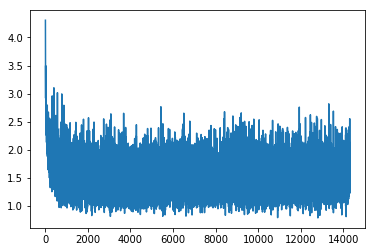

In [85]:
plt.plot(losses)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: